# Notes on current version:
1. Selected countries based on minimal length of response (following 1/100000 aligned start pt) as well as minimal magnitude >=200 deaths

In [1]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For umap, you must:  `pip install umap-learn` and `pip install umap-learn[plot]`

In [2]:
import umap
import umap.plot

In [3]:
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering

In [4]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [5]:
savefigs = False # whether to save specific figures for paper to .../figures directory

# Data

In [6]:
from data import *

getting JHU data...
number of countries listed 274
done with JHU data.  Got  274 countries.
getting owid data...
data for population changes only slowly if at all in OWID database
done with owid data. Got 212 countries
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------


In [7]:
[x for x in covid_owid[0]]

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'tests_per_case',
 'positive_rate',
 'tests_units',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_thousand',
 'life_expectancy',
 'human_development_index']

In [8]:
total_deaths_x = get_data_owid_key('total_deaths')
total_deaths = {cc:total_deaths_x[cc] for cc in total_deaths_x if cc != 'dates' and cc != 'World'}

In [9]:
td_mx = [max(total_deaths[cc]) for cc in total_deaths]
# total_deaths_x['dates'] # to see dates being used

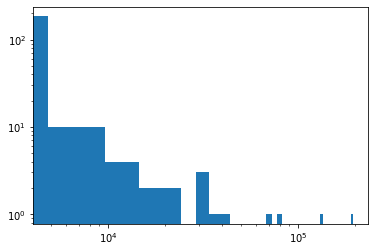

In [10]:
plt.hist(td_mx,bins=40)
plt.yscale('log', nonposy='clip')
plt.xscale('log')

In [11]:
len(td_mx)  # same as nr of countries in totat_deaths

211

In [12]:
len([x for x in td_mx if x>=1000]) # number of countries with >=1000 deaths

50

In [13]:
len([x for x in td_mx if x>=200])  # number of countries with >=200 deaths

96

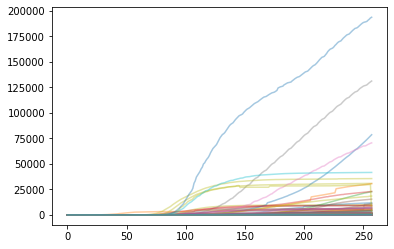

In [14]:
for cc in total_deaths:
    plt.plot(total_deaths[cc],alpha=0.4)

In [15]:
countries = [cc for cc in total_deaths if max(total_deaths[cc])>=200]

In [16]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Bulgaria',
 'Cameroon',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Czech Republic',
 'Democratic Republic of Congo',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Ethiopia',
 'Finland',
 'France',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hungary',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kazakhstan',
 'Kenya',
 'Kosovo',
 'Kuwait',
 'Kyrgyzstan',
 'Lebanon',
 'Libya',
 'Macedonia',
 'Madagascar',
 'Mexico',
 'Moldova',
 'Morocco',
 'Nepal',
 'Netherlands',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Palestine',
 'Panama',
 'Paraguay',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto Rico',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arab

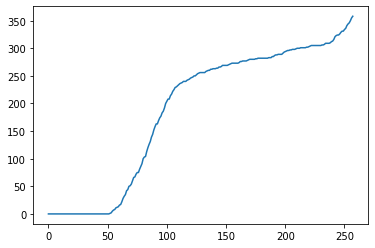

In [17]:
plt.plot(total_deaths['South Korea'])

In [409]:
new_deaths_spm = get_data_owid_key('new_deaths_smoothed_per_million')


In [20]:
print("number of countries",len(countries))

number of countries 96


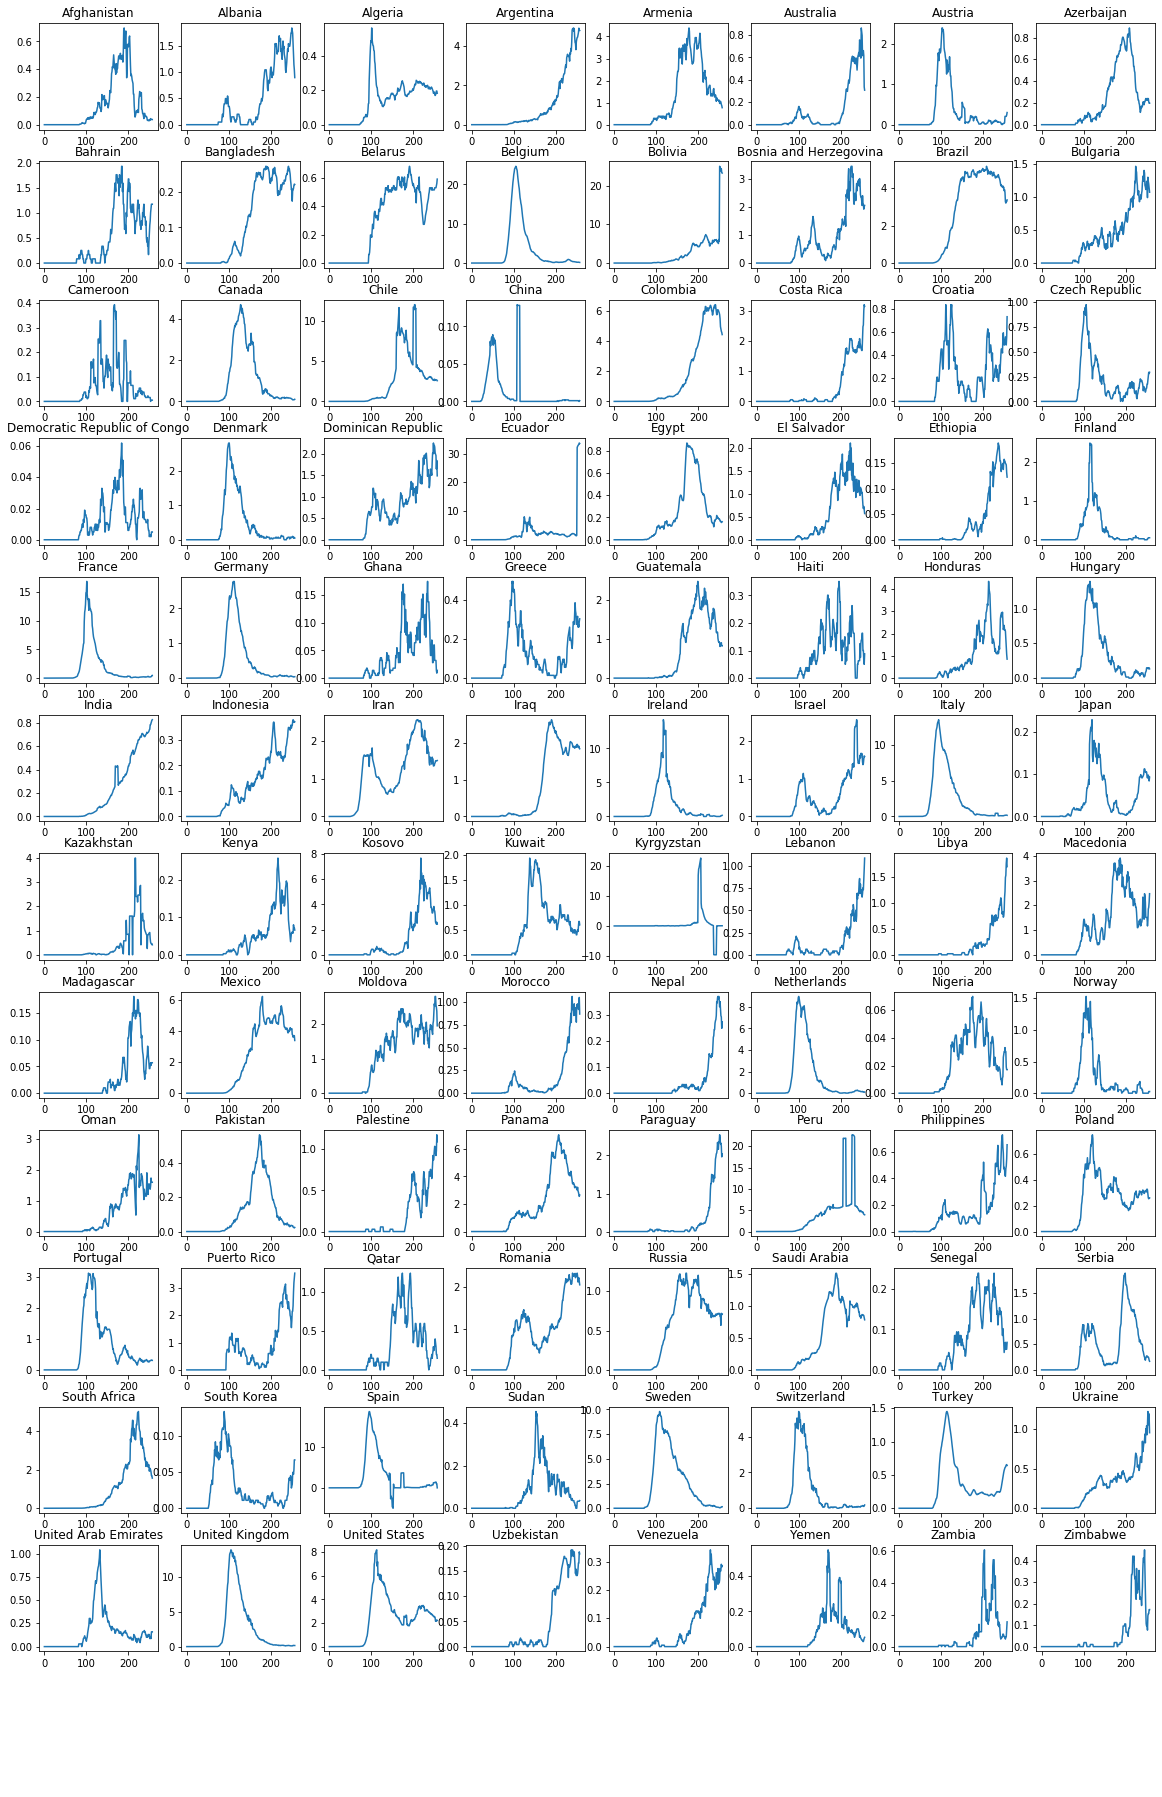

In [27]:

max_cols=8
max_rows=int(len(countries)/max_cols)+1
fsiz = 20/max_cols
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,fsiz*max_rows))
for idx, countrycode  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(new_deaths_spm[countrycode])
    axes[row, col].set_title(countrycode)
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

In [293]:
# scaled so max = 1 for all countries:
scaled = {cc:new_deaths_spm[cc]/max(new_deaths_spm[cc]) for cc in countries}
# get rid of countries with trivially small new_deaths_spm:
# eliminate Peru because of bad spikes.
big = {cc:new_deaths_spm[cc] for cc in countries if max(new_deaths_spm[cc])>1 and cc!='Peru'}

In [294]:
short = {}
thresh = 0.01
for cc in big:
    for i in range(len(big[cc])):
        if big[cc][i] > thresh:
            short[cc] = [big[cc][j] for j in range(i,len(big[cc]))]
            break;
shortest = min([len(short[x]) for x in short])

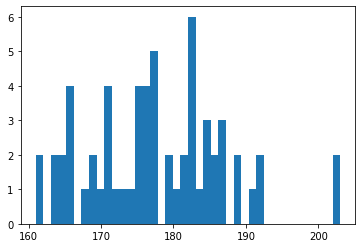

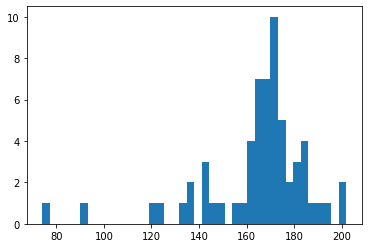

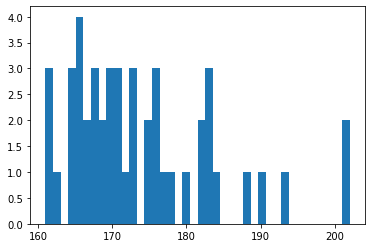

In [295]:
short_t = {}
thresh = 0.01 # threshold of 0.01 per million ie 1/10^8 will not work well for small countries
thresh = 10 # I think maybe better to use day when #total_deaths (ie cumulative) absolute first reaches 10 or perhaps 30 absolute as sync point & keep entire rest of trace
for cc in big:
    tdates = len(total_deaths_x['dates'])
    for i in range(tdates):
        if total_deaths[cc][i] >= thresh:
            short_t[cc] = [big[cc][j] for j in range(i,len(big[cc]))]
            break;
short_test =  min([len(short_t[x]) for x in short_t])
longshort = {cc:short_t[cc] for cc in short_t if (len(short_t[cc])>=160)};
longshortest =  min([len(longshort[x]) for x in longshort])
plt.figure(0)
plt.hist([len(short[x]) for x in short],bins=40);
plt.figure(1)
plt.hist([len(short_t[x]) for x in short_t],bins=40);
plt.figure(2)
#plt.hist([len(short_t[x]) for x in short_t if len(short[x])>=160],bins=40);
plt.hist([len(longshort[x]) for x in longshort],bins=40);

In [296]:
print(len(short),len(short_t),len(longshort))
print(shortest,longshortest)

61 61 47
161 161


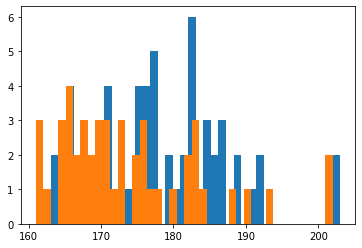

In [297]:
plt.hist([len(short[x]) for x in short],bins=40);
plt.hist([len(longshort[x]) for x in longshort],bins=40);

In [298]:
list(range(10))[:8]

[0, 1, 2, 3, 4, 5, 6, 7]

In [299]:
short_c = {cc:short[cc][:shortest] for cc in short}
longshort_c = {cc:longshort[cc][:longshortest] for cc in longshort}
lcountries = [cc for cc in longshort_c]

In [300]:
len(short['Albania'])

183

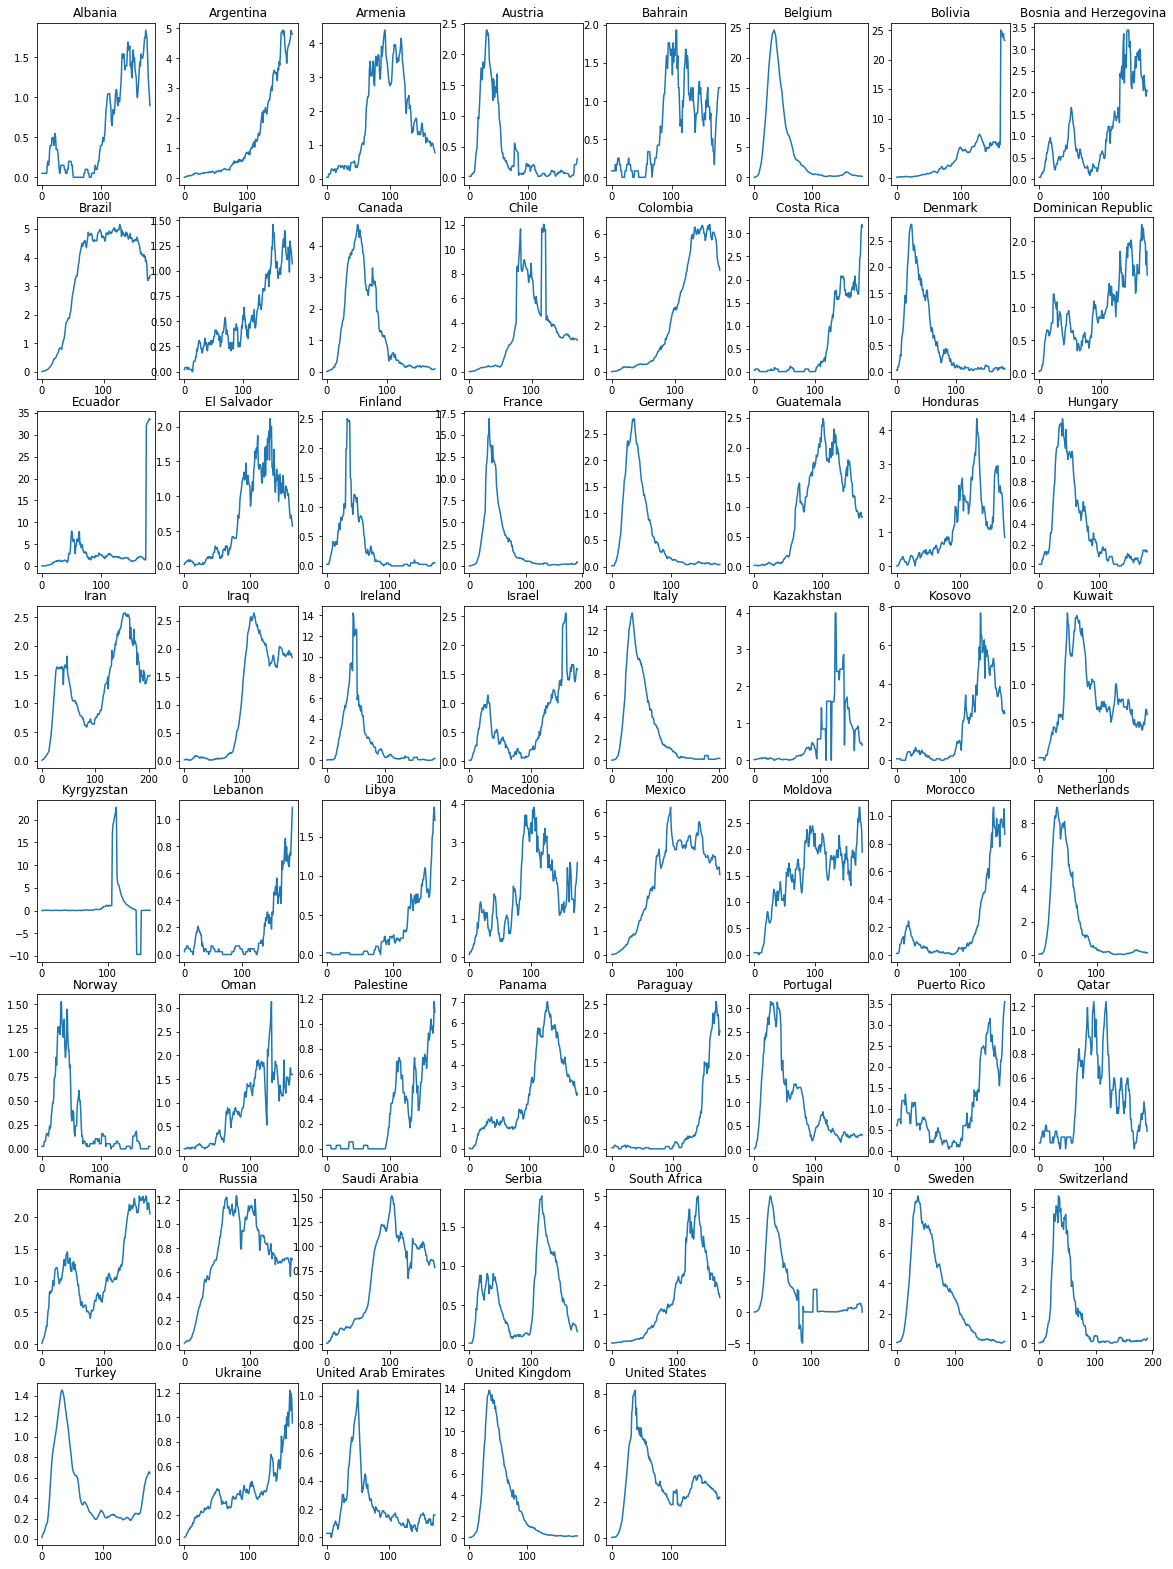

In [301]:
max_cols=8
max_rows=int(len(short)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))
countries = [cc for cc in short]
for idx, countrycode  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(short[countrycode])
    axes[row, col].set_title(countrycode)
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

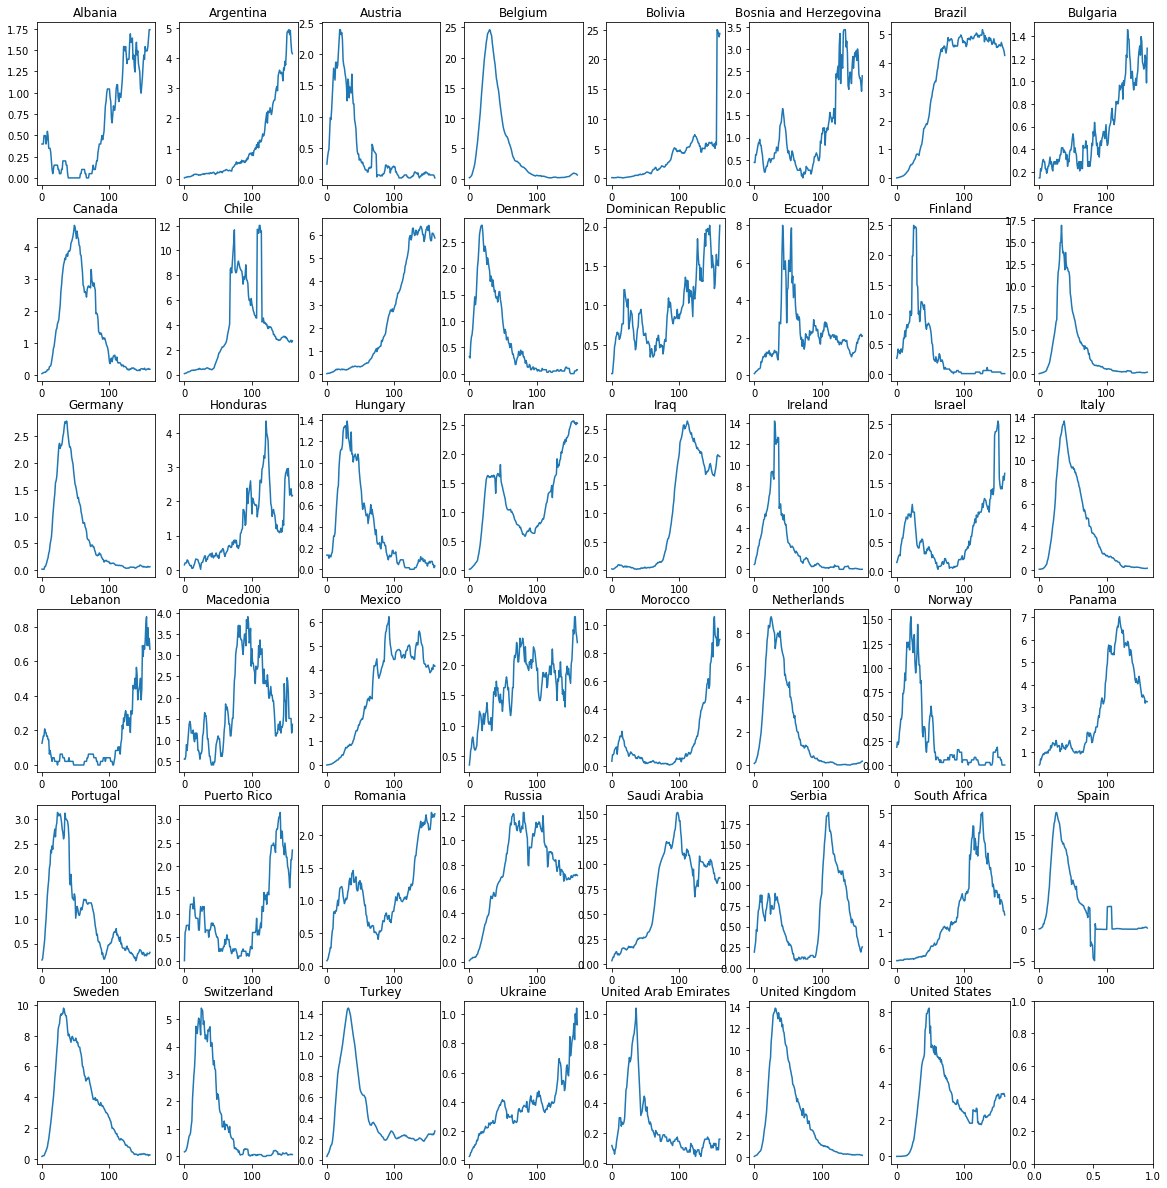

In [302]:
max_cols=8
max_rows=int(len(longshort_c)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))
for idx, countrycode  in enumerate(lcountries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(longshort_c[countrycode])
    axes[row, col].set_title(countrycode)
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

## Cases

In [423]:
new_cases_spm = get_data_owid_key('new_cases_smoothed_per_million')
total_cases_x = get_data_owid_key('total_cases')
total_cases = {cc:total_cases_x[cc] for cc in total_cases_x if cc != 'dates' and cc != 'World'}
total_cases_ppm = get_data_owid_key('total_cases_per_million')
total_cases_ppm = {cc:total_cases_ppm[cc] for cc in total_cases_ppm if cc != 'dates' and cc != 'World'}

In [ ]:
scaled_cases = {cc:new_cases_spm[cc]/max(new_cases_spm[cc]) for cc in countries}
big_cases = {cc:new_cases_spm[cc] for cc in countries if max(new_deaths_spm[cc])>=1}

In [450]:
len(big_cases['Albania'])

258

In [420]:
short_cases = {}
thresh = 0.01
for cc in big_cases:
    for i in range(len(big[cc])):
        if big_cases[cc][i] > thresh:
            short_cases[cc] = [big_cases[cc][j] for j in range(i,len(big_cases[cc]))]
            break;
shortest = min([len(short_cases[x]) for x in short_cases])

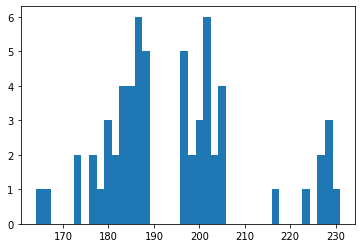

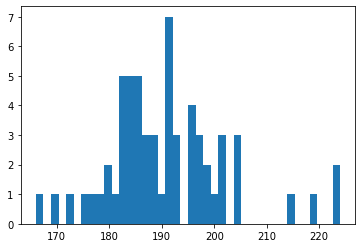

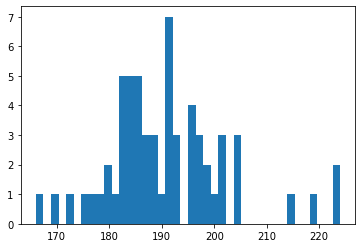

In [424]:
short_cases_t = {}
thresh = 0.01 # threshold of 0.01 per million ie 1/10^8 will not work well for small countries
thresh = 10 # I think maybe better to use day when #total_deaths (ie cumulative) absolute first reaches 10 or perhaps 30 absolute as sync point & keep entire rest of trace
for cc in big:
    tdates = len(total_deaths_x['dates'])
    for i in range(tdates):
        if total_cases[cc][i] >= thresh:
            short_cases_t[cc] = [big_cases[cc][j] for j in range(i,len(big_cases[cc]))]
            break;
short_cases_est =  min([len(short_cases_t[x]) for x in short_cases_t])
longshort_cases = {cc:short_cases_t[cc] for cc in short_cases_t if (len(short_cases_t[cc])>=160)};
longshort_cases_est =  min([len(longshort_cases[x]) for x in longshort_cases])
plt.figure(0)
plt.hist([len(short_cases[x]) for x in short_cases],bins=40);
plt.figure(1)
plt.hist([len(short_cases_t[x]) for x in short_cases_t],bins=40);
plt.figure(2)
#plt.hist([len(short_t[x]) for x in short_t if len(short[x])>=160],bins=40);
plt.hist([len(longshort_cases[x]) for x in longshort_cases],bins=40);

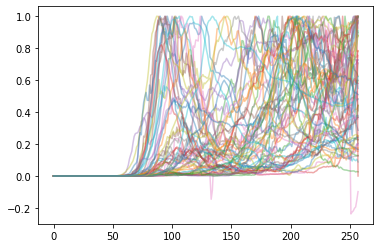

In [426]:
for cc in big_cases:
    plt.plot(scaled_cases[cc],alpha=0.4)

In [428]:
short_cases_c = {cc:short_cases[cc][:short_cases_est] for cc in short_cases}
longshort_cases_c = {cc:longshort_cases[cc][:longshort_cases_est] for cc in longshort_cases}

In [451]:
len(longshort_cases_c['Albania'])

166

# PCA on death data

## PCA with N=10

In [395]:
dat = np.array([longshort_c[cc] for cc in longshort_c])

In [396]:
dat.shape

(47, 161)

In [397]:
pca = PCA(n_components=10)
pca.fit(dat)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [398]:
pca.explained_variance_ratio_

array([0.63326588, 0.21396484, 0.06753755, 0.03490385, 0.01862211,
       0.01130243, 0.00569738, 0.00379426, 0.00263592, 0.00161878])

In [399]:
pca.singular_values_

array([173.18648402, 100.66816589,  56.55794382,  40.65908574,
        29.69855759,  23.1369931 ,  16.42700823,  13.40553832,
        11.17343498,   8.7561833 ])

In [400]:
fitted = pca.fit_transform(dat)

In [401]:
fitted.shape

(47, 10)

In [402]:
smoothed = pca.inverse_transform(fitted)

In [403]:
smoothed.shape

(47, 161)

In [404]:
len(lcountries)

47

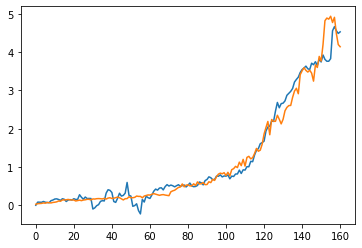

In [405]:
plt.plot(smoothed[1])
plt.plot(dat[1])

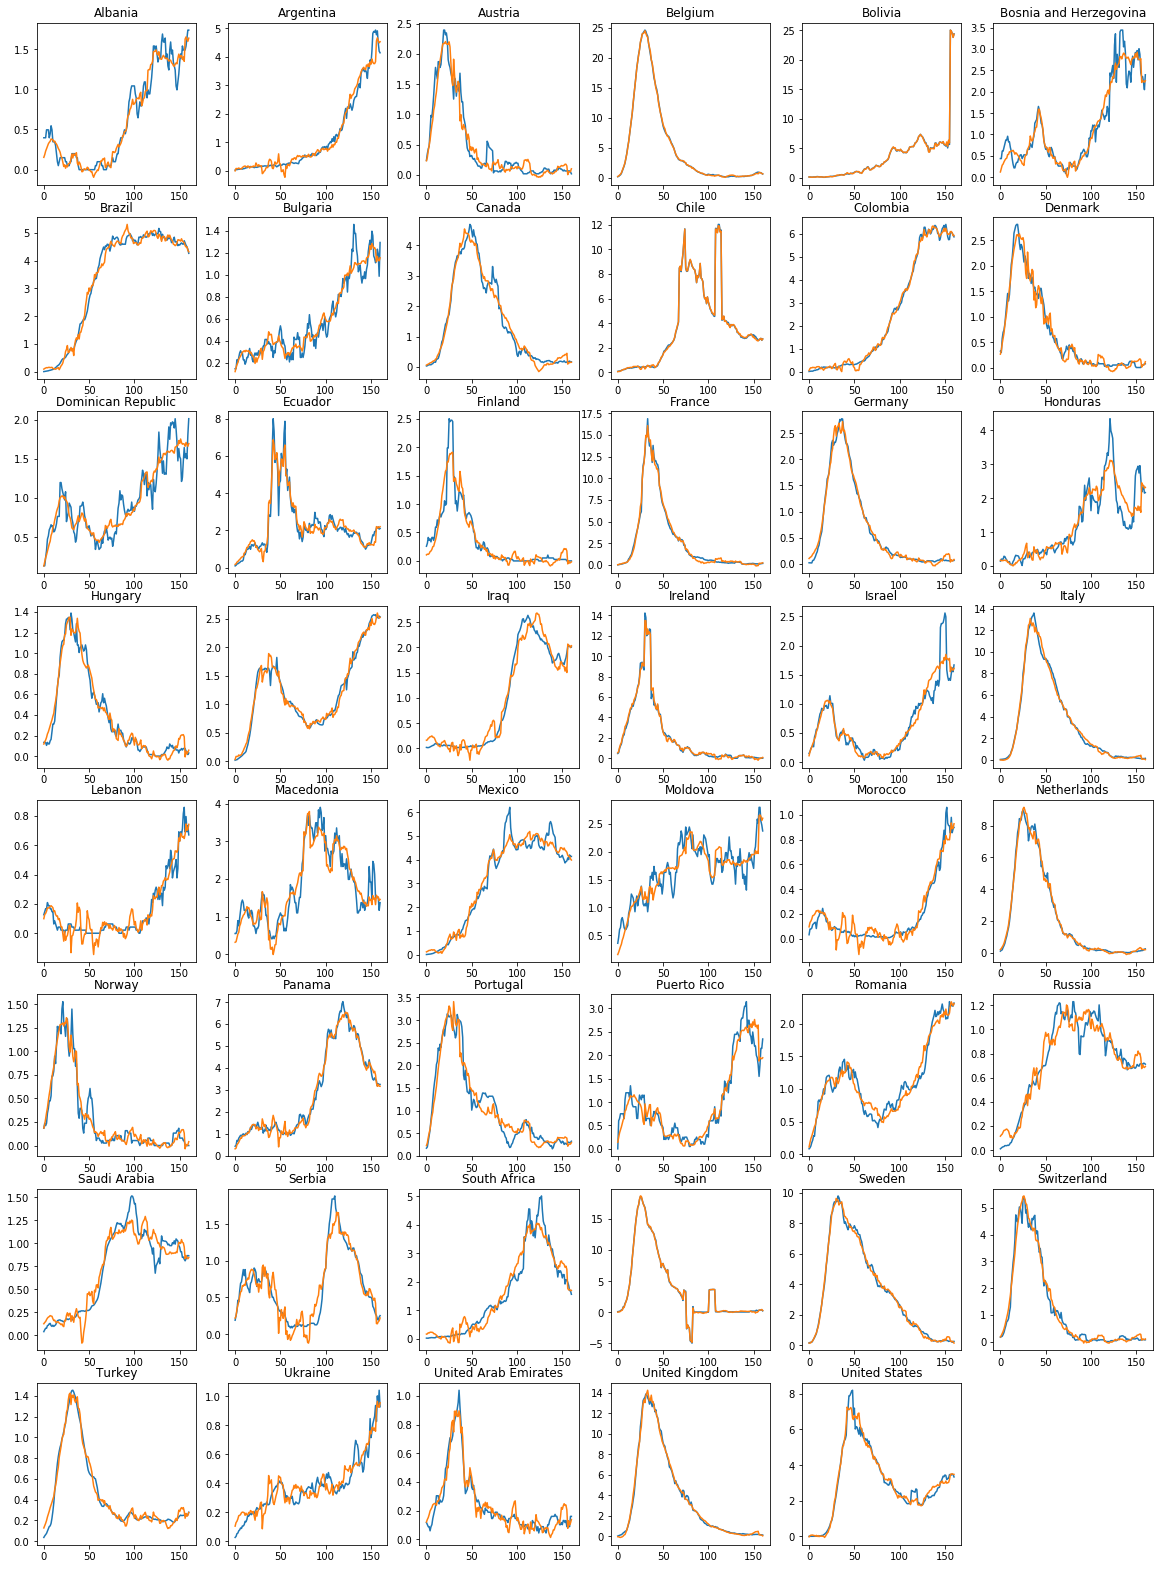

In [406]:
max_cols=6
max_rows=int(len(longshort_c)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))

lcountries = [cc for cc in longshort_c]
for idx, countrycode  in enumerate(lcountries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
for idx in range(len(lcountries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

### umap on raw data

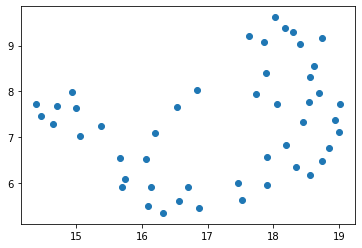

In [52]:
um_raw = umap.UMAP(init="spectral").fit(dat)
umdat = um_raw.embedding_
plt.scatter(umdat[:,0],umdat[:,1])

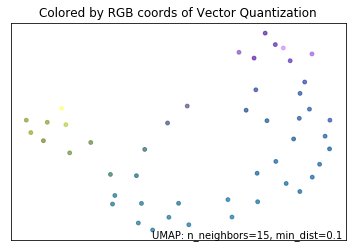

In [53]:
umap.plot.diagnostic(um_raw,diagnostic_type='vq')

### umap on PCA fitted data

In [55]:
um_fit = umap.UMAP(random_state=52,n_neighbors=10).fit(fitted)

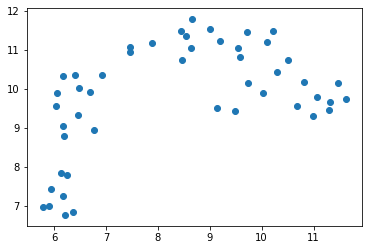

In [57]:
plt.scatter(um_fit.embedding_[:,0],um_fit.embedding_[:,1])

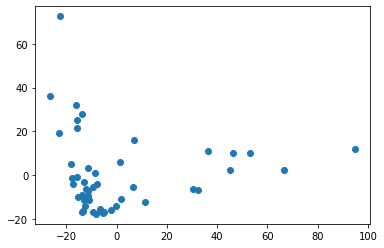

In [59]:
plt.scatter(fitted[:,0],fitted[:,1])

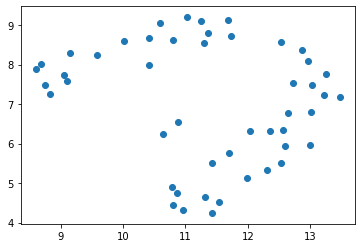

In [65]:
plt.scatter(umdat[:,0],umdat[:,1])

### Clustering the umap output

#### 4 clusters

In [81]:
agclus = AgglomerativeClustering(n_clusters=4)

In [82]:
aglabs = agclus.fit_predict(umdat)

In [83]:
aglabs

array([2, 0, 1, 3, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 3, 1, 0, 1, 0, 0, 3,
       0, 3, 2, 0, 0, 0, 2, 3, 1, 0, 0, 1, 0, 0, 2, 2, 2, 0, 3, 3, 1, 1,
       2, 1, 3, 0])

In [84]:
type(aglabs)

numpy.ndarray

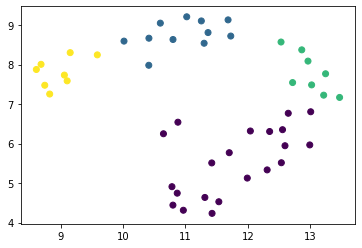

In [85]:
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs)

Consider many (16) umap instantiations, by varying `random_state`, check clusterings of each.

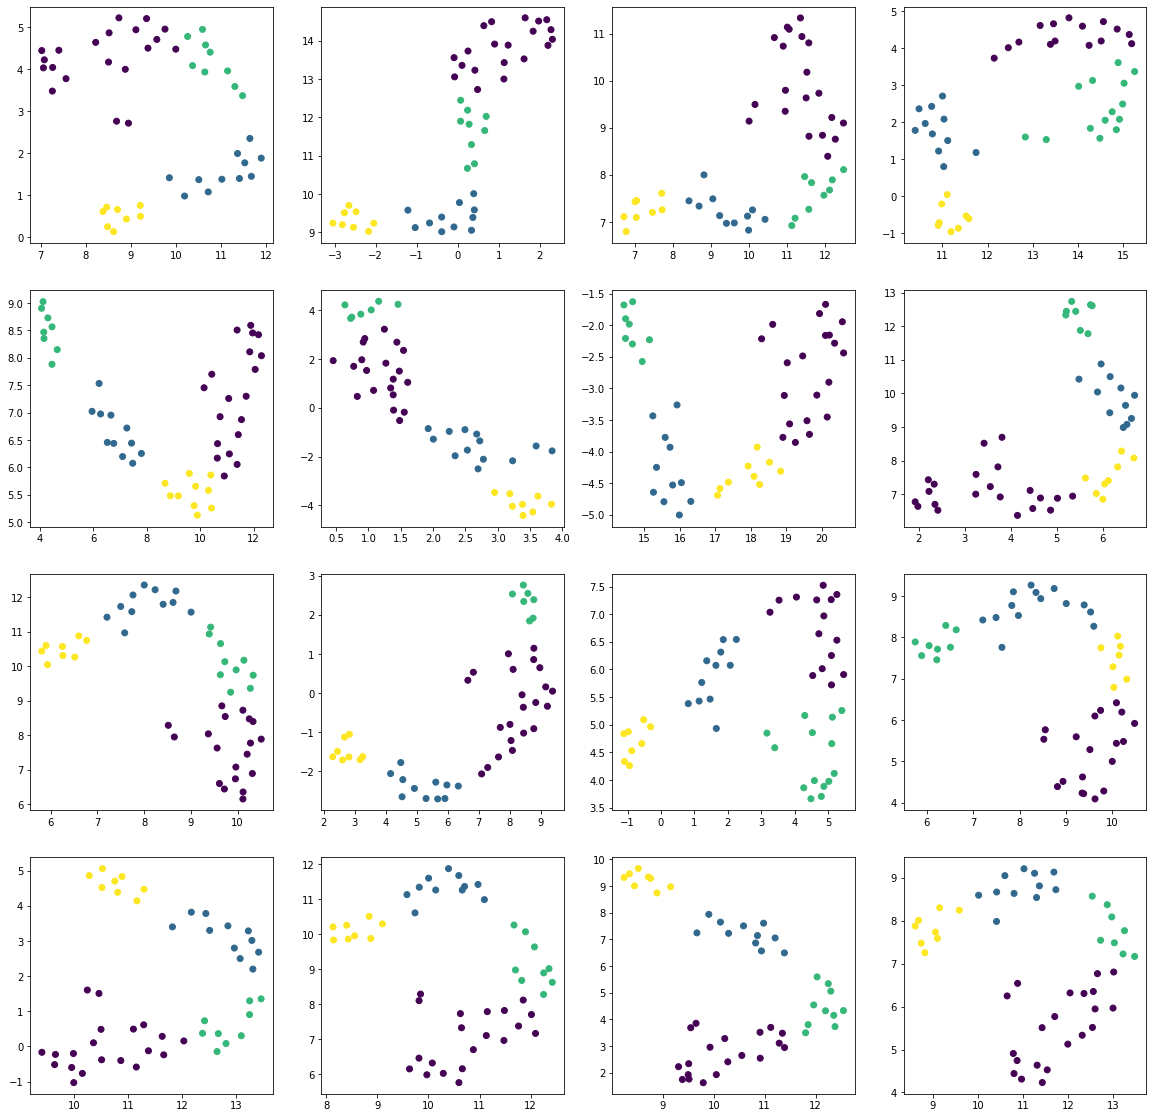

In [87]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=4)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)



Compute correlations between clusterings, component by component.  Gather best correlation between each cluster and clusterings of all other 15.

In [136]:
def corcl(a,b):
    return len(set(a).intersection(set(b)))/float(len(set(a).union(set(b))))
    
def match(a,x):
    rtn = [i for i in range(len(a)) if a[i] == x]
    return rtn
    
def mxcor(m,n):
    cx = []
    for k in range(4):
        m1 = match(m,k)
        m2 = match(n,k)
        cx.append(corcl(m1,m2))
    return max(cx)

corclasses = np.zeros((len(classes),len(classes)))
for i in range(len(classes)-1):
    cc = classes[i]
    for j in range(i+1,len(classes)):
        ccc = classes[j]
        cx = []
        corclasses[i,j] = mxcor(cc,ccc)
        corclasses[j,i] = corclasses[i,j]

for i in range(len(classes)):
    corclasses[i,i] = 1.0
    
    

In [137]:
id2d = np.zeros((len(classes),len(classes)))
cmn = []
foo = np.subtract(corclasses,id2d)
for i in range(len(classes)):
    cmn.append(np.mean(foo[i,:]))
    

In [140]:
[x for x in enumerate(cmn)]

[(0, 0.996875),
 (1, 0.996875),
 (2, 0.996875),
 (3, 0.9866071428571428),
 (4, 0.9903846153846154),
 (5, 0.9516225961538461),
 (6, 0.9903846153846154),
 (7, 0.9903846153846154),
 (8, 1.0),
 (9, 0.9866071428571428),
 (10, 0.9866071428571428),
 (11, 0.9187127976190477),
 (12, 0.996875),
 (13, 0.996875),
 (14, 1.0),
 (15, 0.9940476190476191)]

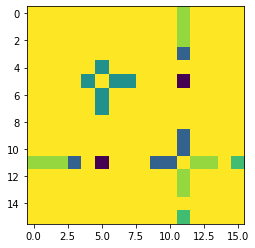

In [139]:
plt.imshow(corclasses)

**Those with perfect match to all others are umaps 8 and 14**:

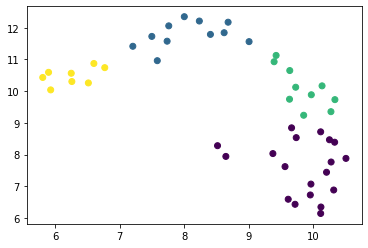

In [142]:
um_fit = umap.UMAP(random_state=8,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=4)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);


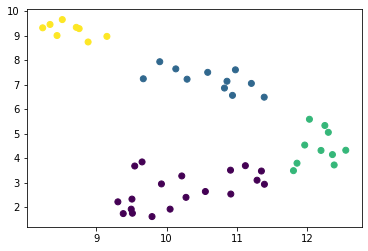

In [143]:
um_fit = umap.UMAP(random_state=14,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=4)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

Of these two we will use 14.

From the cell above, `aglabs` will contain this canonical classification

In [146]:
[x for x in enumerate(aglabs)]

[(0, 2),
 (1, 0),
 (2, 1),
 (3, 3),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 2),
 (8, 1),
 (9, 0),
 (10, 0),
 (11, 1),
 (12, 2),
 (13, 0),
 (14, 1),
 (15, 3),
 (16, 1),
 (17, 0),
 (18, 1),
 (19, 0),
 (20, 0),
 (21, 3),
 (22, 2),
 (23, 3),
 (24, 2),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 2),
 (29, 3),
 (30, 1),
 (31, 0),
 (32, 0),
 (33, 1),
 (34, 0),
 (35, 0),
 (36, 2),
 (37, 2),
 (38, 2),
 (39, 0),
 (40, 3),
 (41, 3),
 (42, 1),
 (43, 1),
 (44, 2),
 (45, 1),
 (46, 3),
 (47, 0)]

#### Graphs of canonical clustering

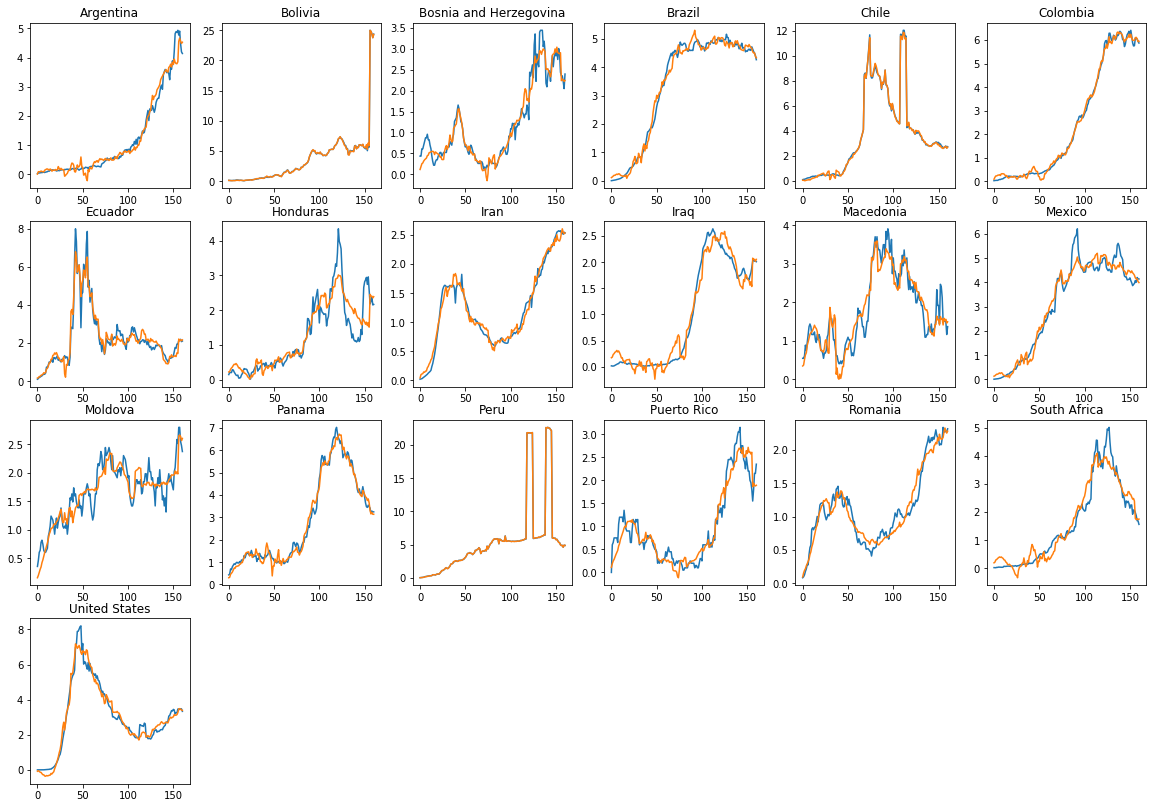

In [147]:
# cluster 0
blob = [i for i in range(len(longshort_c)) if aglabs[i]==0]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

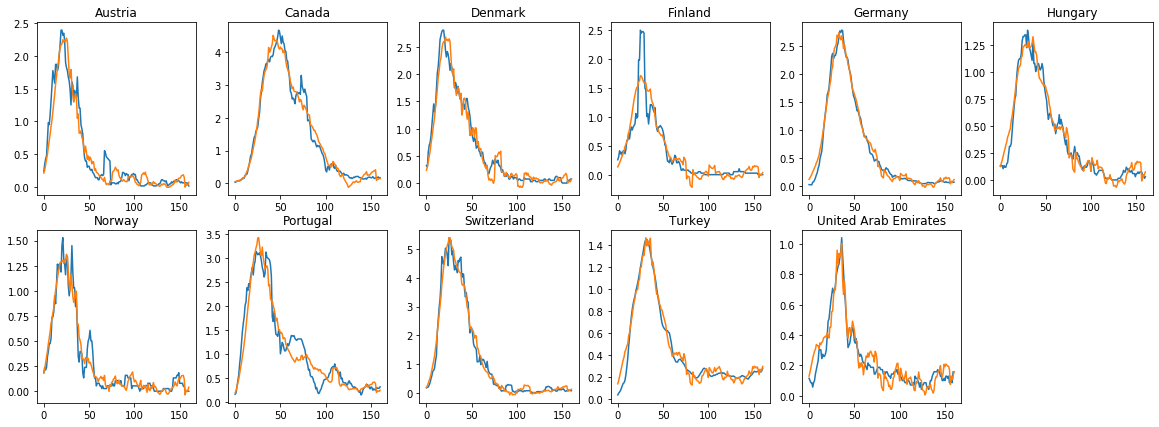

In [148]:
# cluster 1
blob = [i for i in range(len(longshort_c)) if aglabs[i]==1]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# PCA

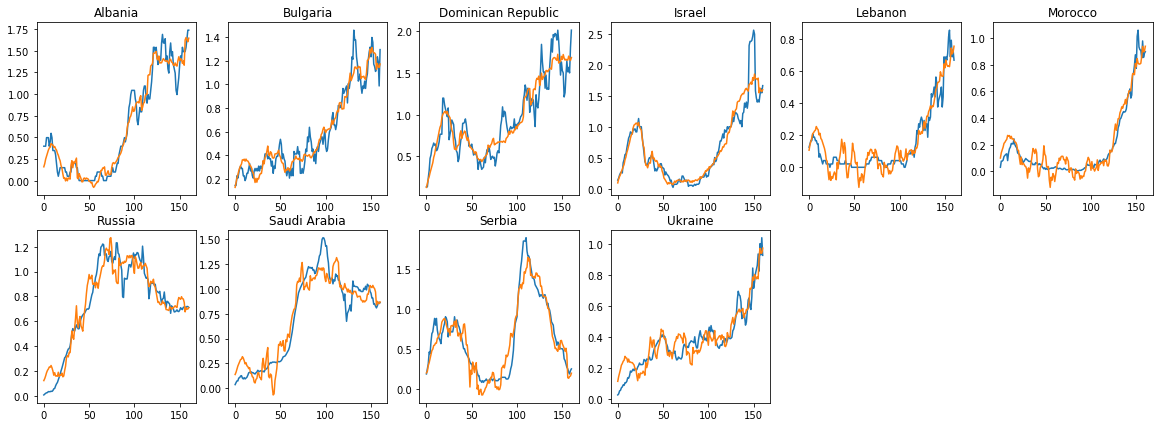

In [149]:
# cluster 2
blob = [i for i in range(len(longshort_c)) if aglabs[i]==2]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

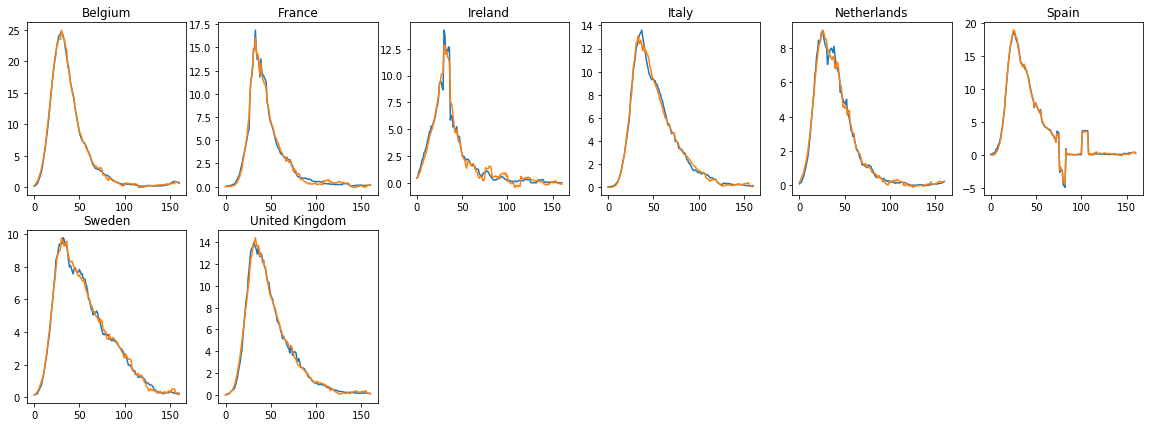

In [150]:
# cluster 3
blob = [i for i in range(len(longshort_c)) if aglabs[i]==3]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

#### 3 clusters

In [151]:
agclus = AgglomerativeClustering(n_clusters=3)

In [152]:
aglabs = agclus.fit_predict(umdat)

In [153]:
aglabs

array([2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       2, 0, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0,
       2, 0, 0, 1])

In [154]:
type(aglabs)

numpy.ndarray

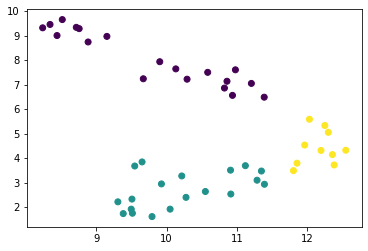

In [155]:
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs)

Consider many (16) umap instantiations, by varying `random_state`, check clusterings of each.

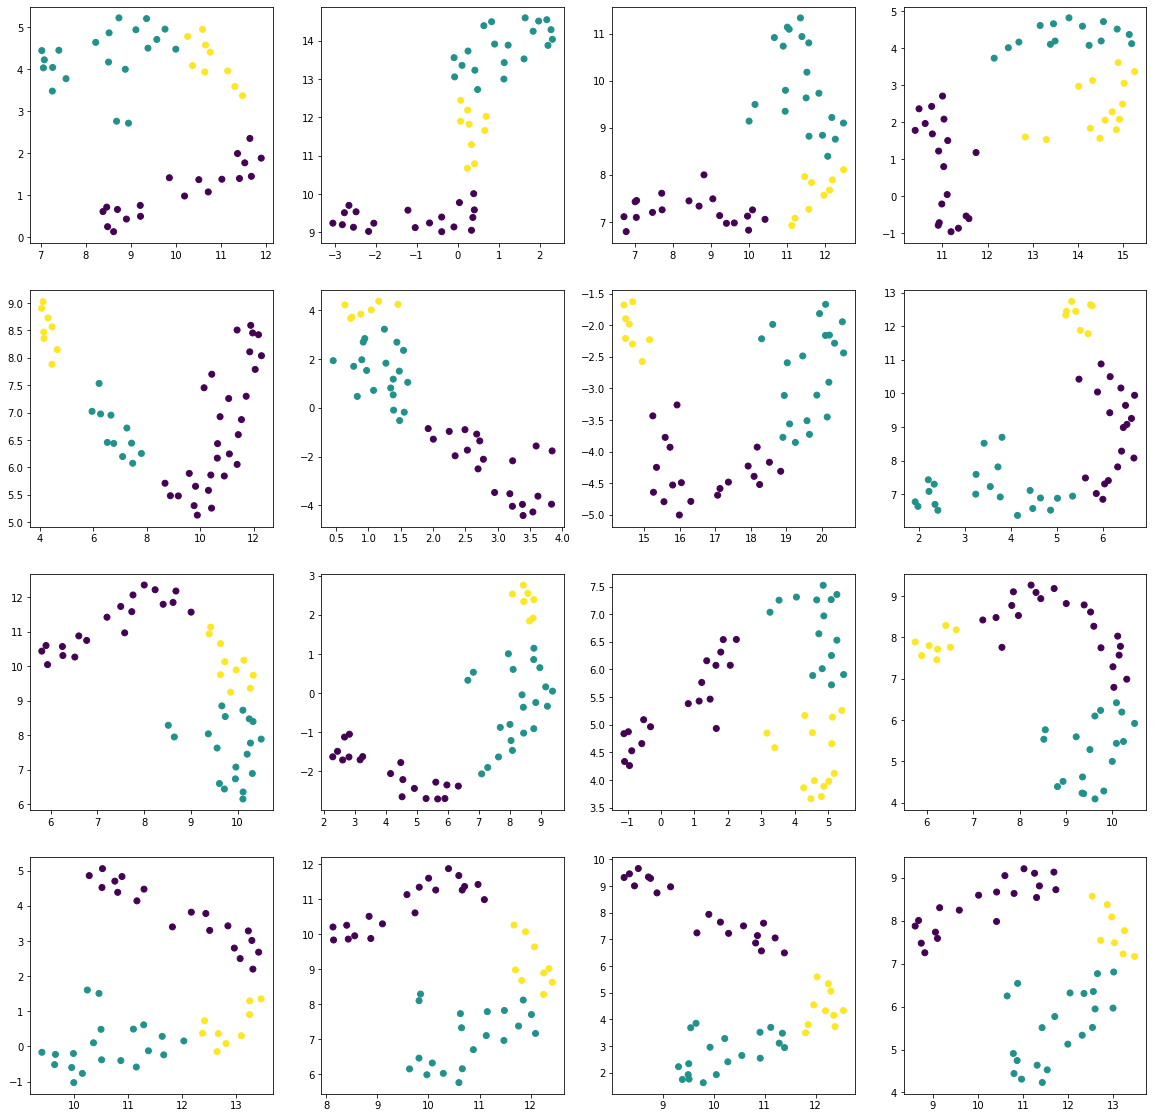

In [157]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=3)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)



Compute correlations between clusterings, component by component.  Gather best correlation between each cluster and clusterings of all other 15.

In [159]:
def corcl(a,b):
    return len(set(a).intersection(set(b)))/float(len(set(a).union(set(b))))
    
def match(a,x):
    rtn = [i for i in range(len(a)) if a[i] == x]
    return rtn
    
def mxcor(m,n):
    cx = []
    for k in range(3):  # 3 for 3 classes
        m1 = match(m,k)
        m2 = match(n,k)
        cx.append(corcl(m1,m2))
    return max(cx)

corclasses = np.zeros((len(classes),len(classes)))
for i in range(len(classes)-1):
    cc = classes[i]
    for j in range(i+1,len(classes)):
        ccc = classes[j]
        cx = []
        corclasses[i,j] = mxcor(cc,ccc)
        corclasses[j,i] = corclasses[i,j]

for i in range(len(classes)):
    corclasses[i,i] = 1.0
    
    

In [160]:
id2d = np.zeros((len(classes),len(classes)))
cmn = []
foo = np.subtract(corclasses,id2d)
for i in range(len(classes)):
    cmn.append(np.mean(foo[i,:]))
    

In [161]:
[x for x in enumerate(cmn)]

[(0, 0.9254464285714286),
 (1, 0.9254464285714286),
 (2, 0.9254464285714286),
 (3, 0.8177710499908776),
 (4, 0.2526041666666667),
 (5, 0.7648267420149373),
 (6, 0.8416050903119869),
 (7, 0.8301746943988324),
 (8, 0.9224702380952381),
 (9, 0.834051724137931),
 (10, 0.8177710499908776),
 (11, 0.8238759004714232),
 (12, 0.9254464285714286),
 (13, 0.9254464285714286),
 (14, 0.9224702380952381),
 (15, 0.9226190476190477)]

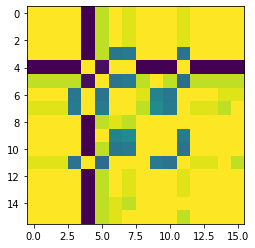

In [162]:
plt.imshow(corclasses)

**Those with highest mean correlation scores are umaps 0,1,2,12,13**:

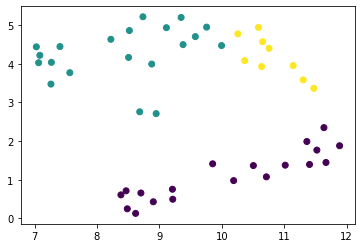

In [166]:
um_fit = umap.UMAP(random_state=0,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);


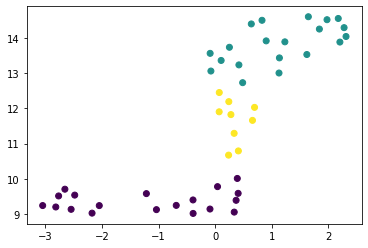

In [165]:
um_fit = umap.UMAP(random_state=1,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

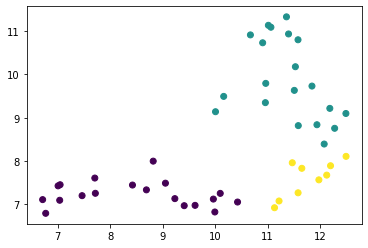

In [168]:
um_fit = umap.UMAP(random_state=2,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

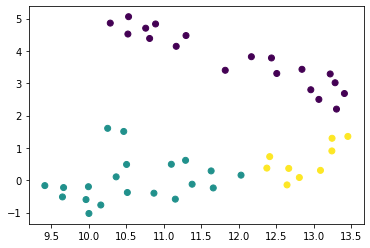

In [169]:
um_fit = umap.UMAP(random_state=12,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

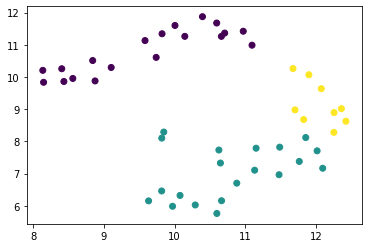

In [171]:
um_fit = umap.UMAP(random_state=13,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

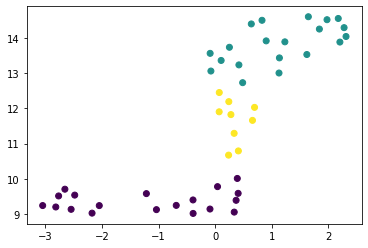

In [172]:
um_fit = umap.UMAP(random_state=1,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);

Of these two we will use 1.

From the cell above, `aglabs` will contain this canonical classification

In [173]:
[x for x in enumerate(aglabs)]

[(0, 2),
 (1, 1),
 (2, 0),
 (3, 0),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 0),
 (9, 1),
 (10, 1),
 (11, 0),
 (12, 1),
 (13, 1),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 1),
 (18, 0),
 (19, 1),
 (20, 1),
 (21, 0),
 (22, 2),
 (23, 0),
 (24, 2),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 0),
 (30, 0),
 (31, 1),
 (32, 1),
 (33, 0),
 (34, 1),
 (35, 1),
 (36, 2),
 (37, 2),
 (38, 2),
 (39, 1),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 2),
 (45, 0),
 (46, 0),
 (47, 1)]

#### Graphs of canonical clustering

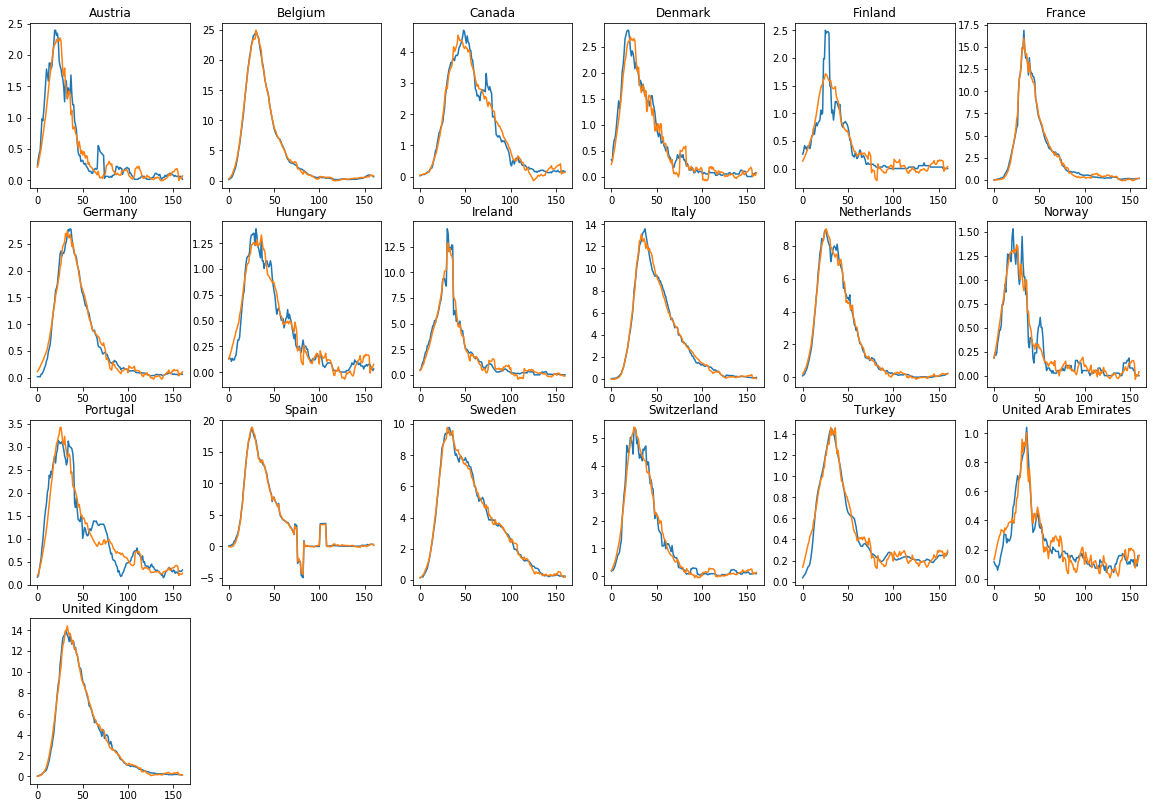

In [174]:
# cluster 0
blob = [i for i in range(len(longshort_c)) if aglabs[i]==0]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

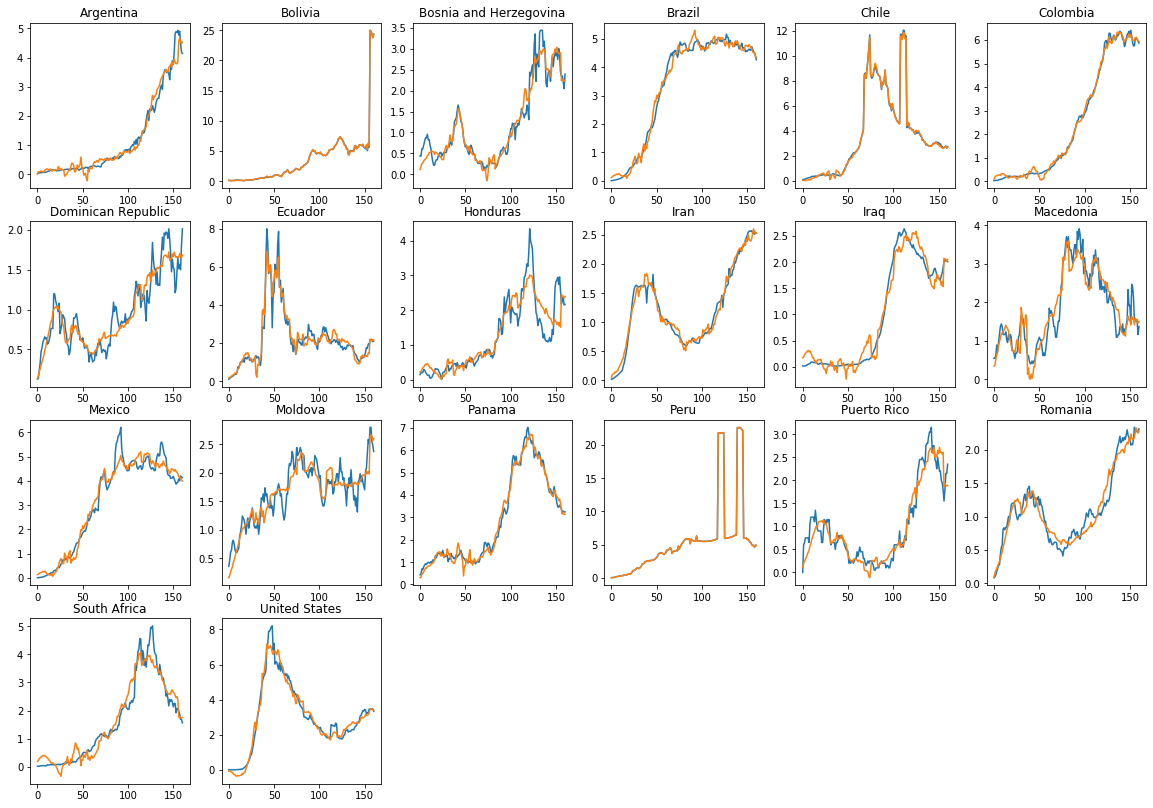

In [175]:
# cluster 1
blob = [i for i in range(len(longshort_c)) if aglabs[i]==1]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# PCA

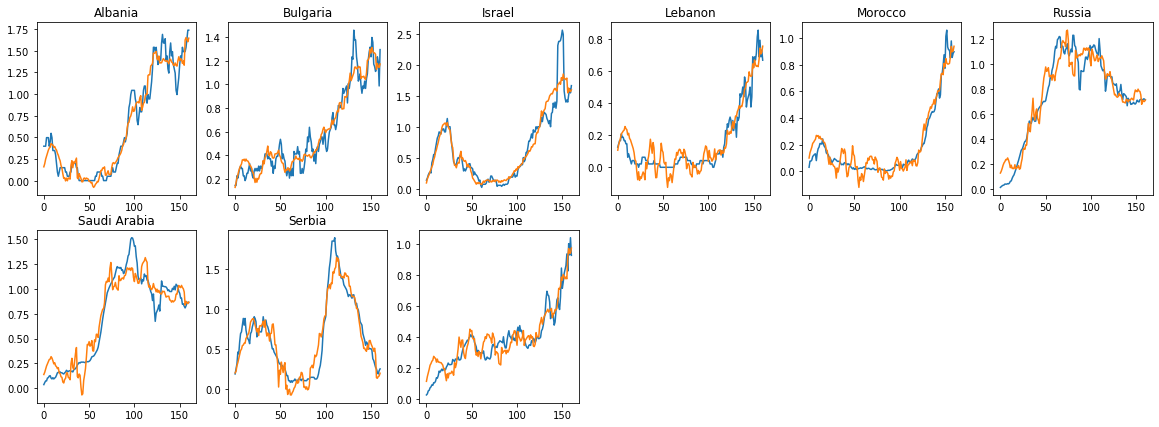

In [176]:
# cluster 2
blob = [i for i in range(len(longshort_c)) if aglabs[i]==2]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

### PCA components

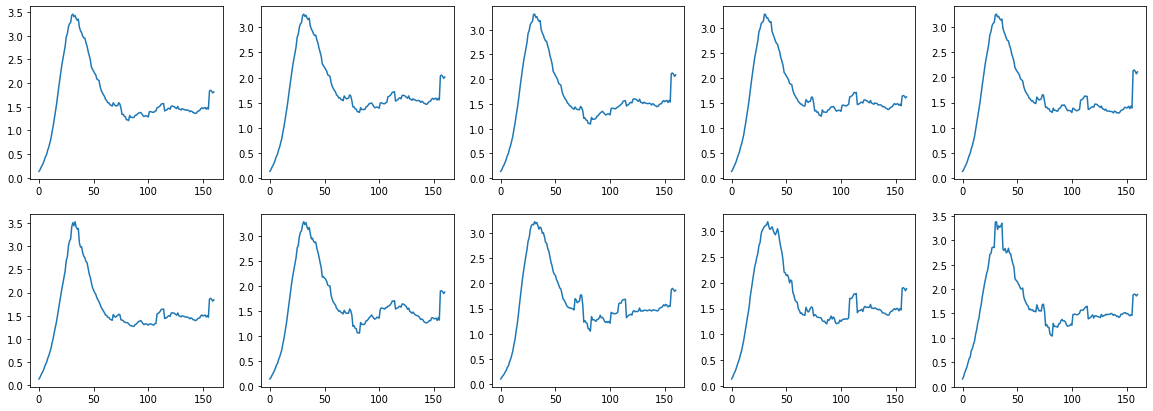

In [407]:
max_rows = 2
max_cols = 5
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
for i in range(10):
    foo = np.zeros(10)
    foo[i] = 1
    mypca = pca.inverse_transform(foo)
    row = i // max_cols
    col = i % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(mypca)

## PCA with N=10, scaled data

dat = np.array([longshort_c[cc] for cc in longshort_c])

In [304]:
dat.shape

(47, 161)

In [305]:
for i in range(len(dat)):
    mx = max(dat[i])
    dat[i] = [dd/mx for dd in dat[i]]

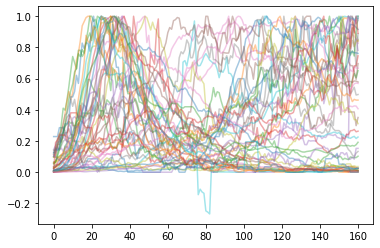

In [306]:
for dd in dat:
    plt.plot(dd,alpha=0.4)

In [307]:
pca = PCA(n_components=10)
pca.fit(dat)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [308]:
pca.explained_variance_ratio_

array([0.59965376, 0.18805521, 0.06799764, 0.05703657, 0.02882976,
       0.01102269, 0.00756903, 0.00593634, 0.00476691, 0.00441693])

In [309]:
pca.singular_values_

array([19.42374885, 10.87740884,  6.54078222,  5.99045039,  4.25895718,
        2.63345935,  2.18224126,  1.9326011 ,  1.73181427,  1.66702761])

In [310]:
fitted = pca.fit_transform(dat)

In [311]:
fitted.shape

(47, 10)

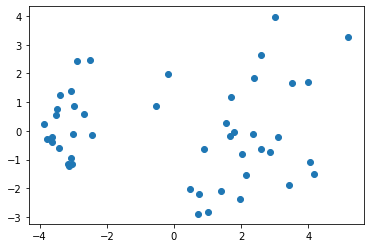

In [312]:
plt.scatter(fitted[:,0],fitted[:,1])

In [313]:
smoothed = pca.inverse_transform(fitted)

In [314]:
smoothed.shape

(47, 161)

In [315]:
len(lcountries)

47

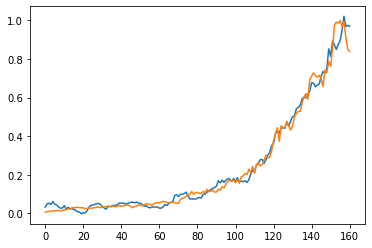

In [316]:
plt.plot(smoothed[1])
plt.plot(dat[1])

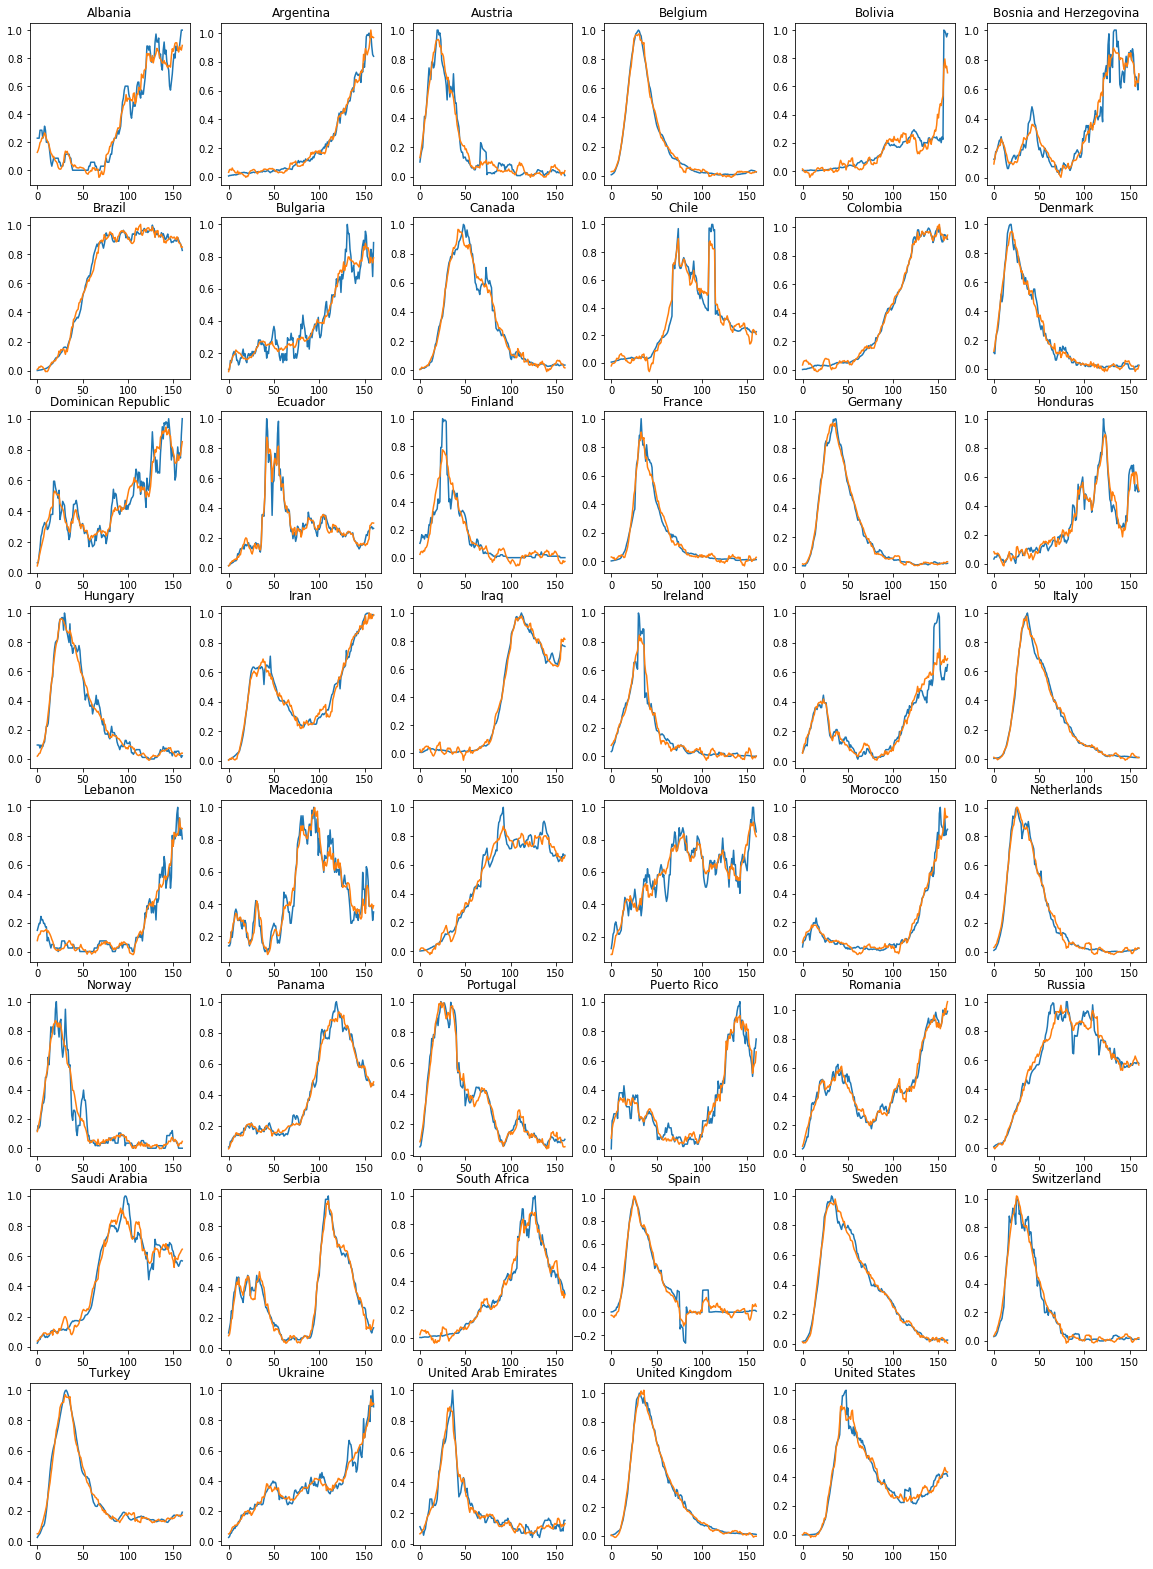

In [317]:
max_cols=6
max_rows=int(len(longshort_c)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))

lcountries = [cc for cc in longshort_c]
for idx, countrycode  in enumerate(lcountries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
for idx in range(len(lcountries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

### umap on raw data

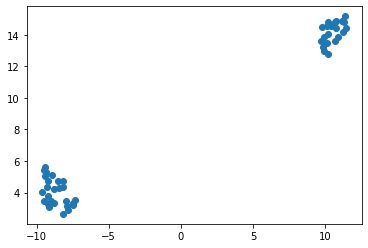

In [318]:
um_raw = umap.UMAP(init="spectral").fit(dat)
umdat = um_raw.embedding_
plt.scatter(umdat[:,0],umdat[:,1])

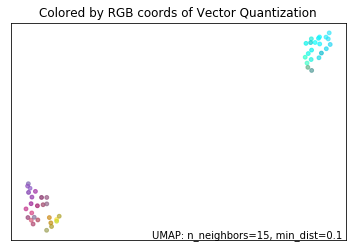

In [319]:
umap.plot.diagnostic(um_raw,diagnostic_type='vq')

### umap on PCA fitted data

In [320]:
um_fit = umap.UMAP(random_state=52,n_neighbors=10).fit(fitted)

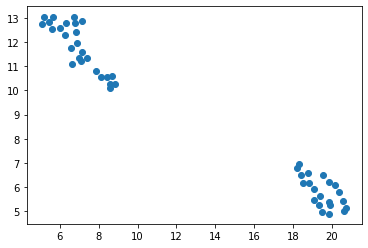

In [321]:
plt.scatter(um_fit.embedding_[:,0],um_fit.embedding_[:,1])

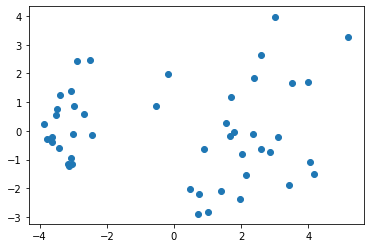

In [322]:
plt.scatter(fitted[:,0],fitted[:,1])

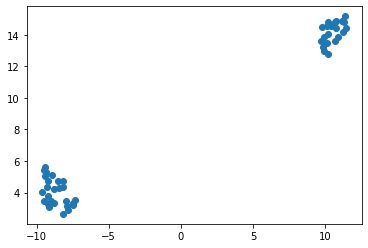

In [323]:
plt.scatter(umdat[:,0],umdat[:,1])

### Clustering the umap output

#### 2 clusters

In [324]:
agclus = AgglomerativeClustering(n_clusters=2)

In [325]:
aglabs = agclus.fit_predict(umdat)

In [326]:
aglabs

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1])

In [327]:
type(aglabs)

numpy.ndarray

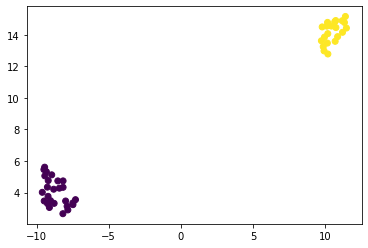

In [328]:
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs)

Consider many (16) umap instantiations, by varying `random_state`, check clusterings of each.

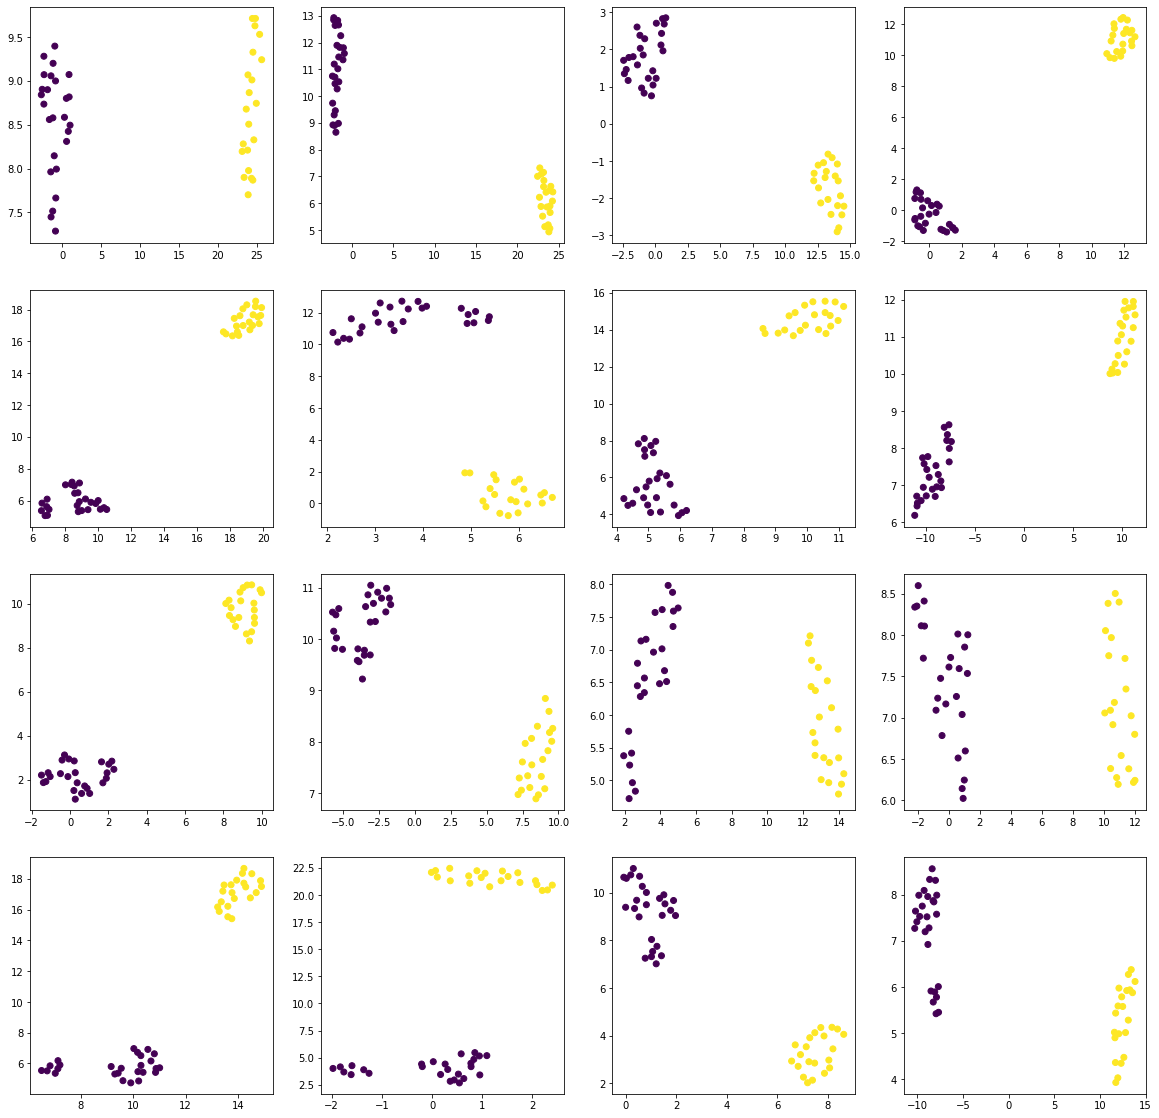

In [329]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=2)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)



Compute correlations between clusterings, component by component.  Gather best correlation between each cluster and clusterings of all other 15.

In [330]:
def corcl(a,b):
    return len(set(a).intersection(set(b)))/float(len(set(a).union(set(b))))
    
def match(a,x):
    rtn = [i for i in range(len(a)) if a[i] == x]
    return rtn
    
def mxcor(m,n):
    cx = []
    for k in range(2):
        m1 = match(m,k)
        m2 = match(n,k)
        cx.append(corcl(m1,m2))
    return max(cx)

corclasses = np.zeros((len(classes),len(classes)))
for i in range(len(classes)-1):
    cc = classes[i]
    for j in range(i+1,len(classes)):
        ccc = classes[j]
        cx = []
        corclasses[i,j] = mxcor(cc,ccc)
        corclasses[j,i] = corclasses[i,j]

for i in range(len(classes)):
    corclasses[i,i] = 1.0
    
    

In [331]:
id2d = np.zeros((len(classes),len(classes)))
cmn = []
foo = np.subtract(corclasses,id2d)
for i in range(len(classes)):
    cmn.append(np.mean(foo[i,:]))
    

In [332]:
[x for x in enumerate(cmn)]

[(0, 1.0),
 (1, 1.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0),
 (10, 1.0),
 (11, 1.0),
 (12, 1.0),
 (13, 1.0),
 (14, 1.0),
 (15, 1.0)]

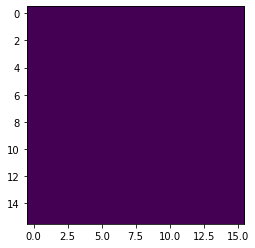

In [333]:
plt.imshow(corclasses)

**All have perfect match.  2 is fine for canonical:**

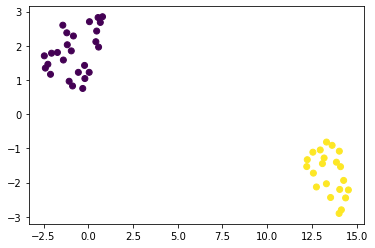

In [335]:
um_fit = umap.UMAP(random_state=2,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=2)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);


In [336]:
[x for x in enumerate(aglabs)]

[(0, 0),
 (1, 0),
 (2, 1),
 (3, 1),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 1),
 (9, 0),
 (10, 0),
 (11, 1),
 (12, 0),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 0),
 (18, 1),
 (19, 0),
 (20, 0),
 (21, 1),
 (22, 0),
 (23, 1),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 1),
 (30, 1),
 (31, 0),
 (32, 1),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 0),
 (44, 1),
 (45, 1),
 (46, 1)]

In [337]:
[(x[0],lcountries[x[0]],x[1]) for x in enumerate(aglabs)]

[(0, 'Albania', 0),
 (1, 'Argentina', 0),
 (2, 'Austria', 1),
 (3, 'Belgium', 1),
 (4, 'Bolivia', 0),
 (5, 'Bosnia and Herzegovina', 0),
 (6, 'Brazil', 0),
 (7, 'Bulgaria', 0),
 (8, 'Canada', 1),
 (9, 'Chile', 0),
 (10, 'Colombia', 0),
 (11, 'Denmark', 1),
 (12, 'Dominican Republic', 0),
 (13, 'Ecuador', 1),
 (14, 'Finland', 1),
 (15, 'France', 1),
 (16, 'Germany', 1),
 (17, 'Honduras', 0),
 (18, 'Hungary', 1),
 (19, 'Iran', 0),
 (20, 'Iraq', 0),
 (21, 'Ireland', 1),
 (22, 'Israel', 0),
 (23, 'Italy', 1),
 (24, 'Lebanon', 0),
 (25, 'Macedonia', 0),
 (26, 'Mexico', 0),
 (27, 'Moldova', 0),
 (28, 'Morocco', 0),
 (29, 'Netherlands', 1),
 (30, 'Norway', 1),
 (31, 'Panama', 0),
 (32, 'Portugal', 1),
 (33, 'Puerto Rico', 0),
 (34, 'Romania', 0),
 (35, 'Russia', 0),
 (36, 'Saudi Arabia', 0),
 (37, 'Serbia', 0),
 (38, 'South Africa', 0),
 (39, 'Spain', 1),
 (40, 'Sweden', 1),
 (41, 'Switzerland', 1),
 (42, 'Turkey', 1),
 (43, 'Ukraine', 0),
 (44, 'United Arab Emirates', 1),
 (45, 'United Kingd

#### Graphs of canonical clustering

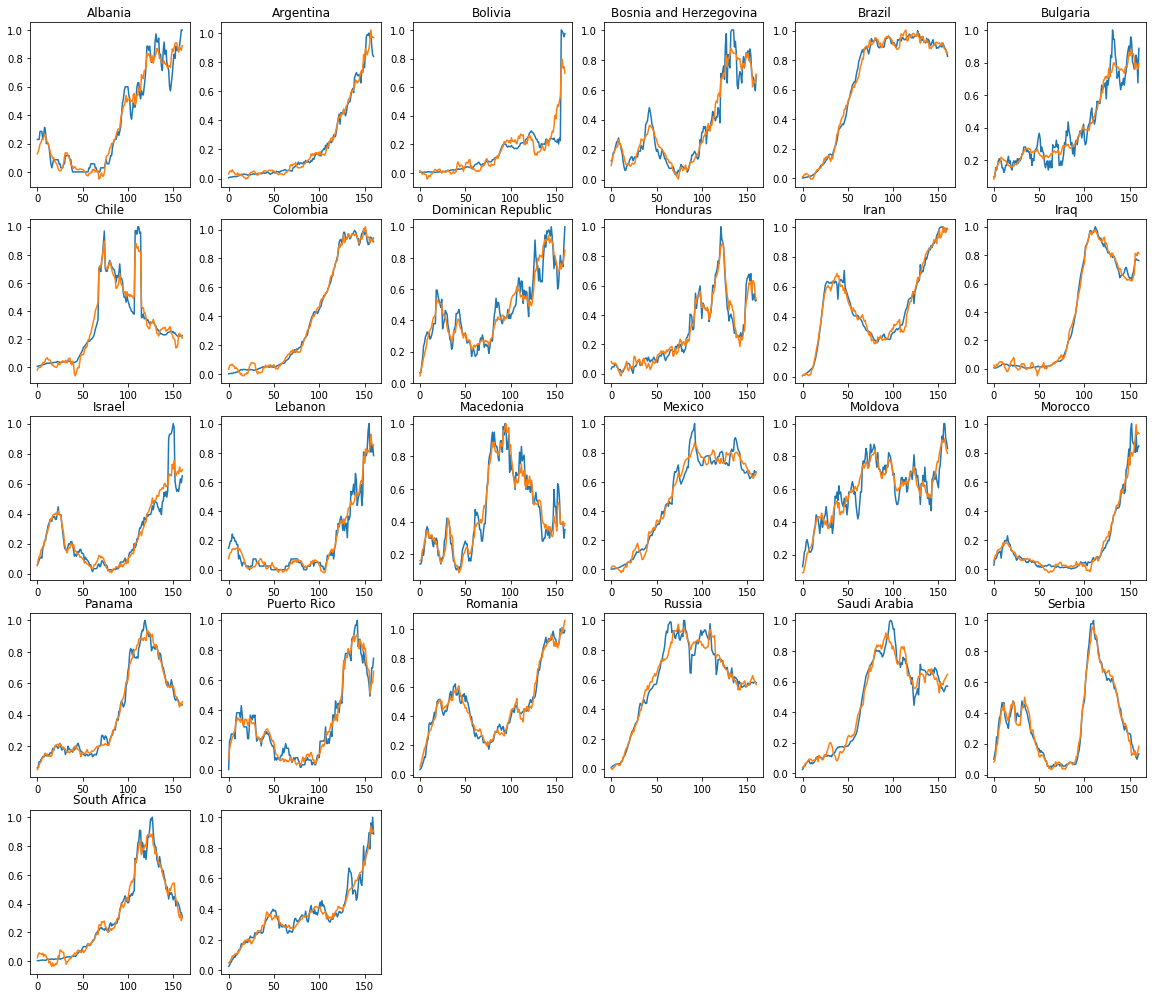

In [338]:
# cluster 0
blob = [i for i in range(len(longshort_c)) if aglabs[i]==0]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

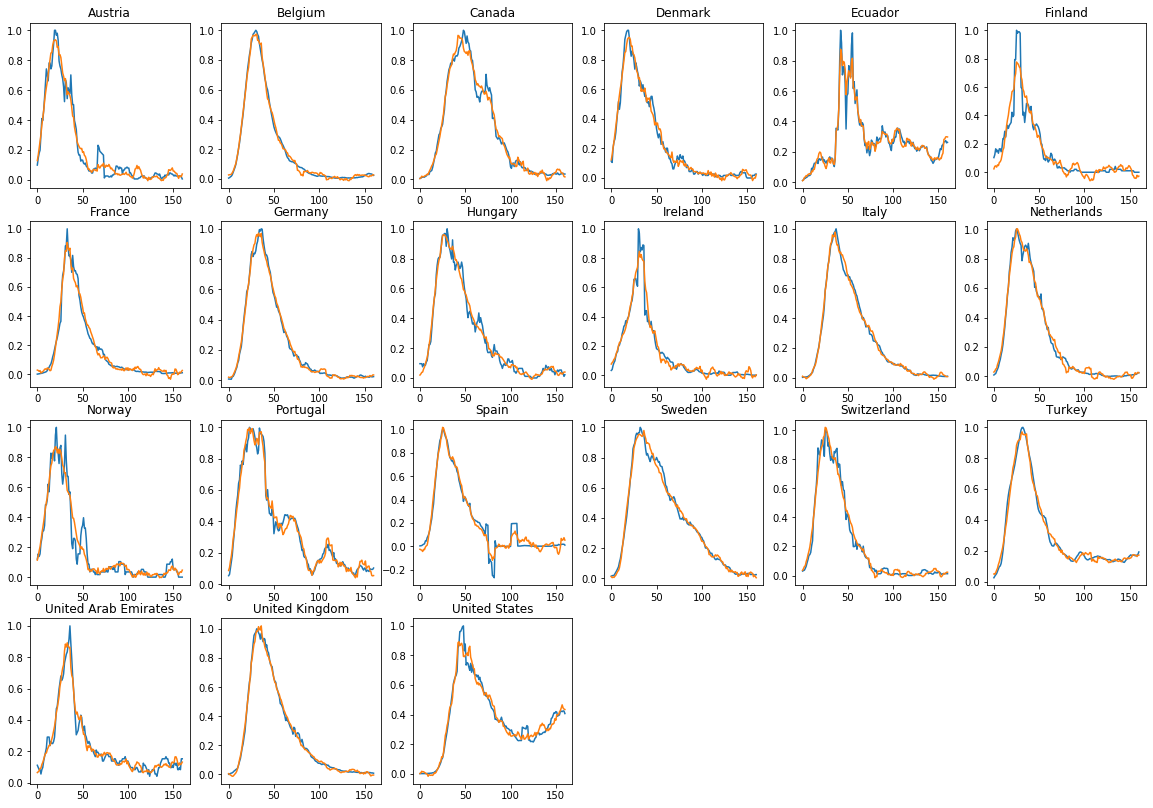

In [339]:
# cluster 1
blob = [i for i in range(len(longshort_c)) if aglabs[i]==1]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# PCA

#### 3 clusters

In [340]:
agclus = AgglomerativeClustering(n_clusters=3)

In [341]:
aglabs = agclus.fit_predict(umdat)

In [342]:
aglabs

array([1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0])

In [343]:
type(aglabs)

numpy.ndarray

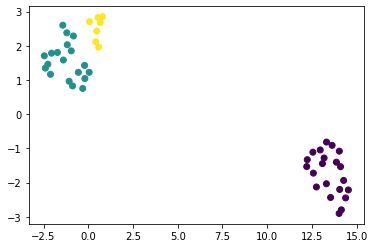

In [344]:
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs)

Consider many (16) umap instantiations, by varying `random_state`, check clusterings of each.

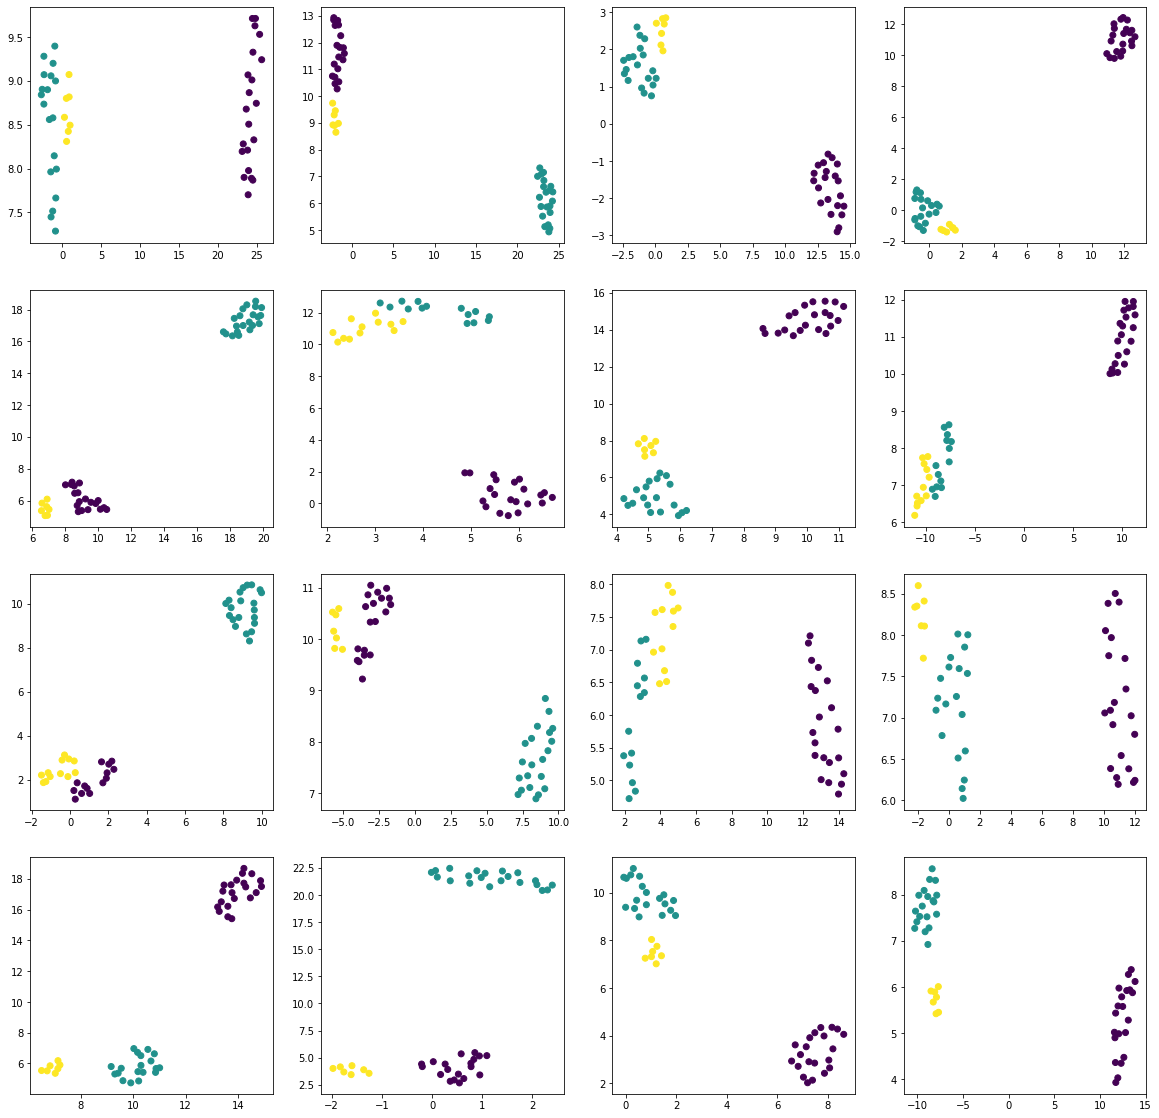

In [345]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=3)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)



Compute correlations between clusterings, component by component.  Gather best correlation between each cluster and clusterings of all other 15.

In [351]:
def corcl(a,b):
    return len(set(a).intersection(set(b)))/float(len(set(a).union(set(b))))
    
def match(a,x):
    rtn = [i for i in range(len(a)) if a[i] == x]
    return rtn
    
def mxcor(m,n):
    cx = []
    for k in range(3):  # 3 for 3 classes
        m1 = match(m,k)
        m2 = match(n,k)
        cx.append(corcl(m1,m2))
    return max(cx)

corclasses = np.zeros((len(classes),len(classes)))
for i in range(len(classes)-1):
    cc = classes[i]
    for j in range(i+1,len(classes)):
        ccc = classes[j]
        cx = []
        corclasses[i,j] = mxcor(cc,ccc)
        corclasses[j,i] = corclasses[i,j]

for i in range(len(classes)):
    corclasses[i,i] = 1.0
    
    

In [352]:
id2d = np.zeros((len(classes),len(classes)))
cmn = []
foo = np.subtract(corclasses,id2d)
for i in range(len(classes)):
    cmn.append(np.mean(foo[i,:]))
    

In [353]:
[x for x in enumerate(cmn)]

[(0, 0.9375),
 (1, 0.8125),
 (2, 0.9375),
 (3, 0.9375),
 (4, 0.8125),
 (5, 0.75),
 (6, 0.9375),
 (7, 0.75),
 (8, 0.5),
 (9, 0.8125),
 (10, 0.75),
 (11, 0.9375),
 (12, 0.9375),
 (13, 0.8125),
 (14, 0.9375),
 (15, 0.9375)]

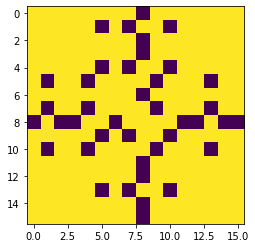

In [354]:
plt.imshow(corclasses)

**12 is good.**

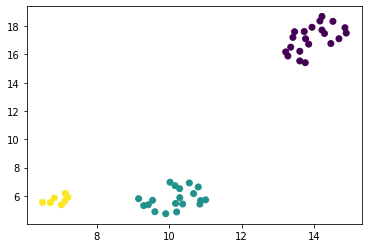

In [355]:
um_fit = umap.UMAP(random_state=12,n_neighbors=10).fit(fitted)
agclus = AgglomerativeClustering(n_clusters=3)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs);


Of these two we will use 1.

From the cell above, `aglabs` will contain this canonical classification

In [356]:
[(x[0],lcountries[x[0]],x[1]) for x in enumerate(aglabs)]

[(0, 'Albania', 1),
 (1, 'Argentina', 1),
 (2, 'Austria', 0),
 (3, 'Belgium', 0),
 (4, 'Bolivia', 1),
 (5, 'Bosnia and Herzegovina', 1),
 (6, 'Brazil', 2),
 (7, 'Bulgaria', 1),
 (8, 'Canada', 0),
 (9, 'Chile', 2),
 (10, 'Colombia', 1),
 (11, 'Denmark', 0),
 (12, 'Dominican Republic', 1),
 (13, 'Ecuador', 0),
 (14, 'Finland', 0),
 (15, 'France', 0),
 (16, 'Germany', 0),
 (17, 'Honduras', 1),
 (18, 'Hungary', 0),
 (19, 'Iran', 1),
 (20, 'Iraq', 1),
 (21, 'Ireland', 0),
 (22, 'Israel', 1),
 (23, 'Italy', 0),
 (24, 'Lebanon', 1),
 (25, 'Macedonia', 2),
 (26, 'Mexico', 2),
 (27, 'Moldova', 2),
 (28, 'Morocco', 1),
 (29, 'Netherlands', 0),
 (30, 'Norway', 0),
 (31, 'Panama', 1),
 (32, 'Portugal', 0),
 (33, 'Puerto Rico', 1),
 (34, 'Romania', 1),
 (35, 'Russia', 2),
 (36, 'Saudi Arabia', 2),
 (37, 'Serbia', 1),
 (38, 'South Africa', 1),
 (39, 'Spain', 0),
 (40, 'Sweden', 0),
 (41, 'Switzerland', 0),
 (42, 'Turkey', 0),
 (43, 'Ukraine', 1),
 (44, 'United Arab Emirates', 0),
 (45, 'United Kingd

#### Graphs of canonical clustering

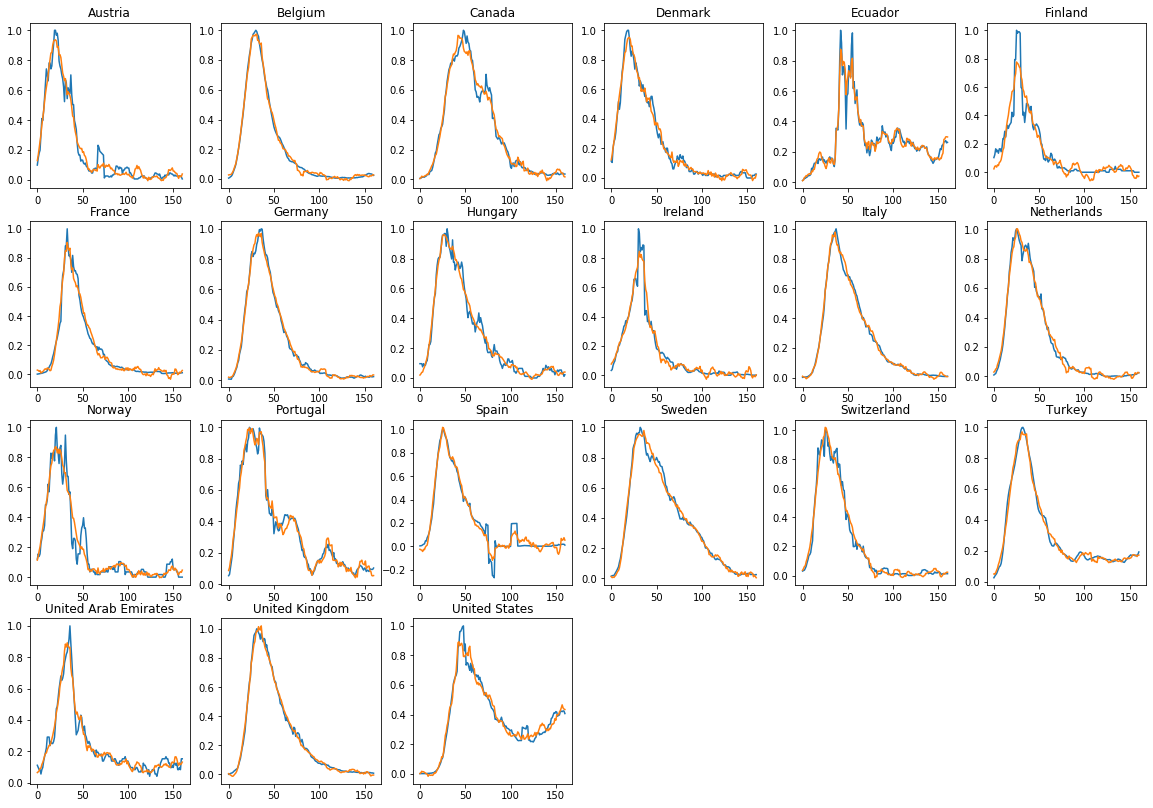

In [357]:
# cluster 0
blob = [i for i in range(len(longshort_c)) if aglabs[i]==0]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

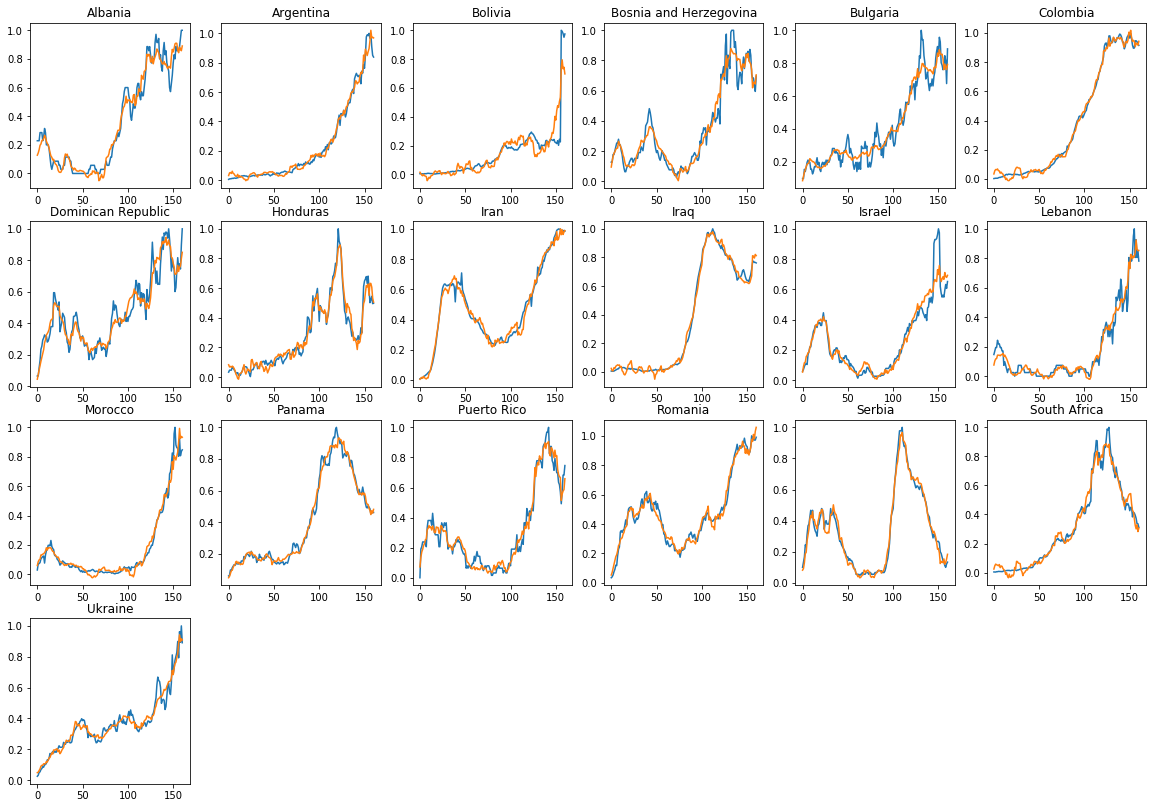

In [358]:
# cluster 1
blob = [i for i in range(len(longshort_c)) if aglabs[i]==1]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# PCA

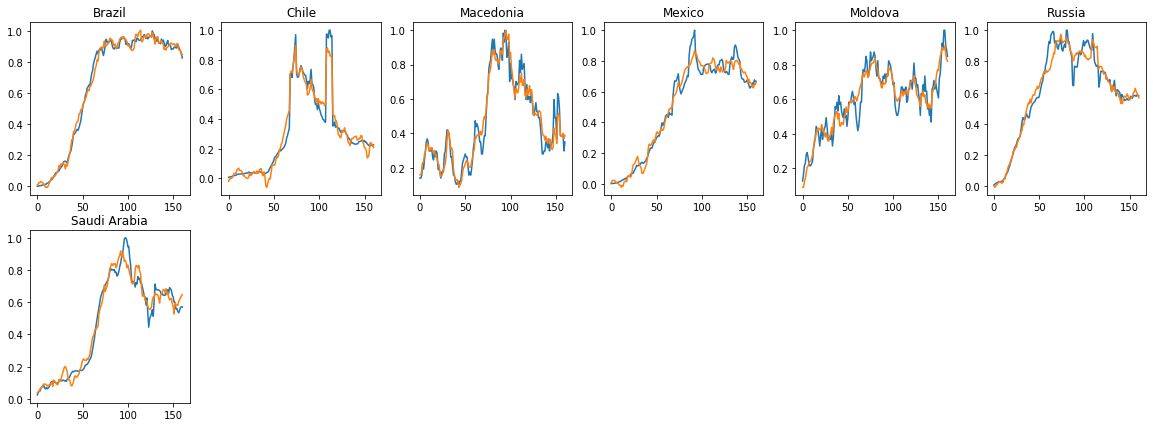

In [359]:
# cluster 2
blob = [i for i in range(len(longshort_c)) if aglabs[i]==2]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

### Visualizing each PCA

In [360]:
fitted.shape

(47, 10)

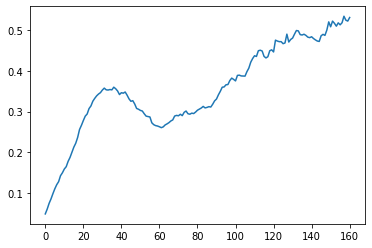

In [361]:
foo = np.zeros(10)
foo[0] = 1
pca0 = pca.inverse_transform(foo)
plt.plot(pca0);

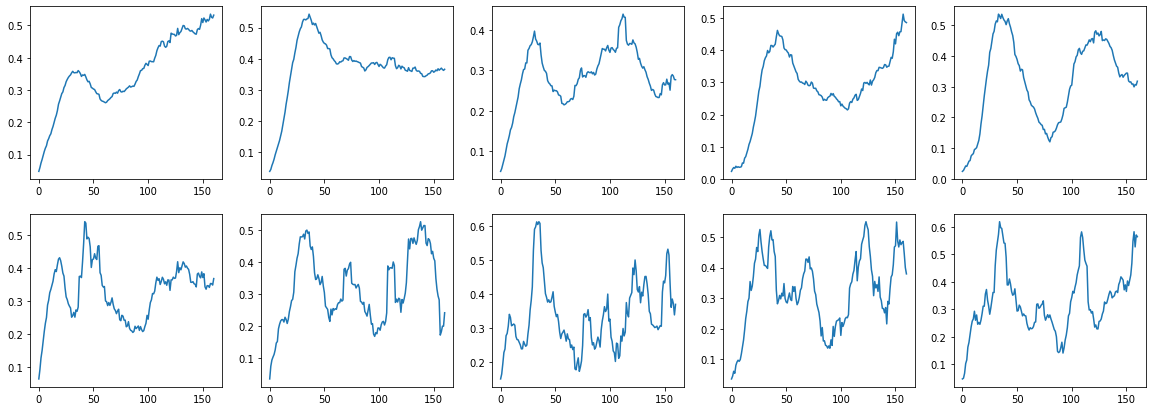

In [362]:
max_rows = 2
max_cols = 5
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
for i in range(10):
    foo = np.zeros(10)
    foo[i] = 1
    mypca = pca.inverse_transform(foo)
    row = i // max_cols
    col = i % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(mypca)

much nicer with the scaled data.

## PCA, N=5

In [363]:
dat = np.array([longshort_c[cc] for cc in longshort_c])

In [364]:
dat.shape

(47, 161)

In [383]:
mx = [max(dd) for dd in dat]
dat = [[dd/mx[i] for dd in dat[i]] for i in range(len(dat))]

In [384]:
pca = PCA(n_components=5)
pca.fit(dat)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [385]:
pca.explained_variance_ratio_

array([0.59965376, 0.18805521, 0.06799764, 0.05703657, 0.02882976])

In [386]:
pca.singular_values_

array([19.42374885, 10.87740884,  6.54078222,  5.99045039,  4.25895718])

In [387]:
fitted = pca.fit_transform(dat)

In [388]:
fitted.shape

(47, 5)

In [389]:
smoothed = pca.inverse_transform(fitted)

In [390]:
smoothed.shape

(47, 161)

In [391]:
len(countries)

61

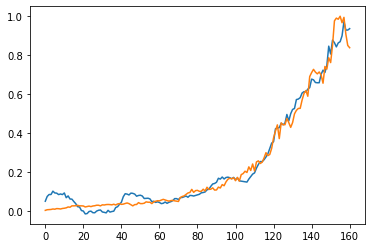

In [392]:
plt.plot(smoothed[1])
plt.plot(dat[1])

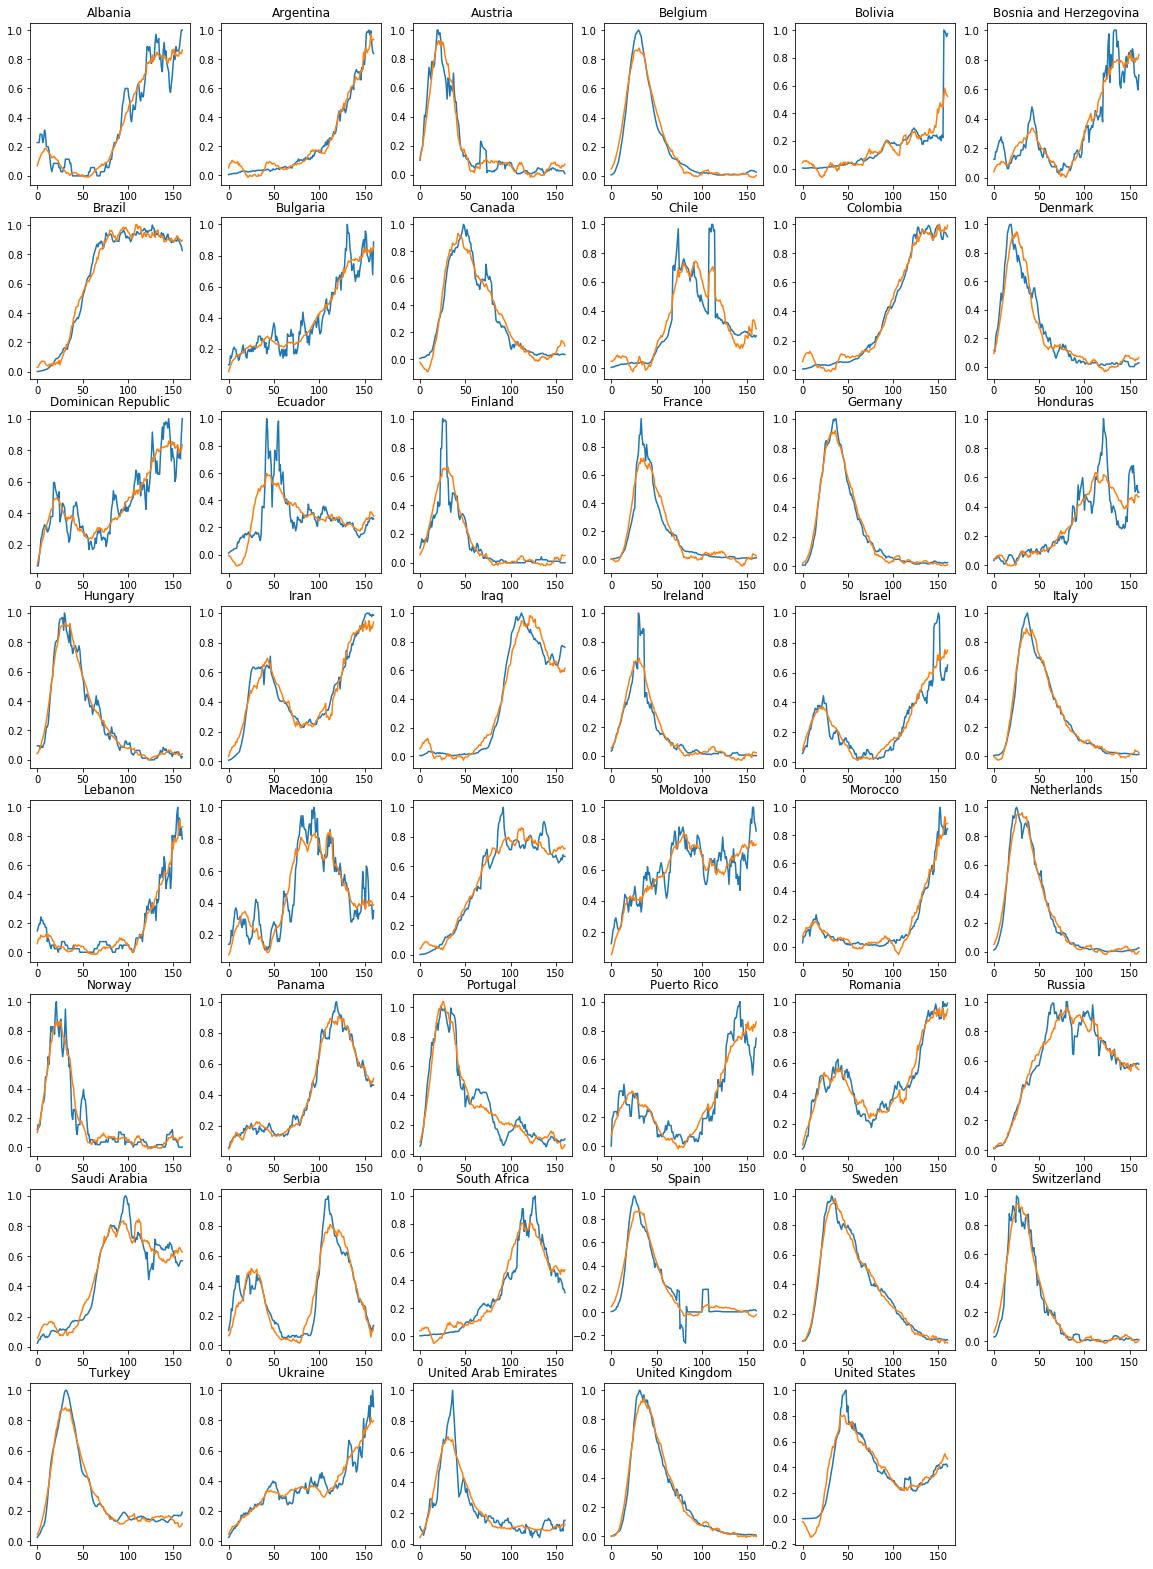

In [393]:
max_cols=6
max_rows=int(len(longshort_c)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))

lcountries = [cc for cc in longshort_c]
for idx, countrycode  in enumerate(lcountries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
for idx in range(len(lcountries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()


**Cursory comparison of N=5 PCA with N=10 PCA indicates that N=10 is noticably less noisy.
Let's go with N=10**

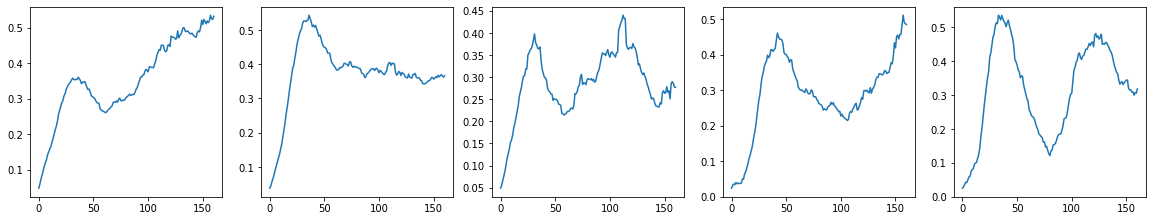

In [394]:
max_rows = 1
max_cols = 5
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
for i in range(5):
    foo = np.zeros(5)
    foo[i] = 1
    mypca = pca.inverse_transform(foo)
    row = i // max_cols
    col = i % max_cols
    #axes[row, col].axis("off")
    axes[i].plot(mypca)

In [381]:
axes[0].plot(mypca)

# PCA on cases

61


In [431]:
countries = [cc for cc in longshort_cases_c]
dat = np.array([longshort_cases_c[cc] for cc in longshort_cases_c])
mx = [max(dd) for dd in dat]
dat = [[dd/mx[i] for dd in dat[i]] for i in range(len(dat))]

In [430]:
len(countries)

61

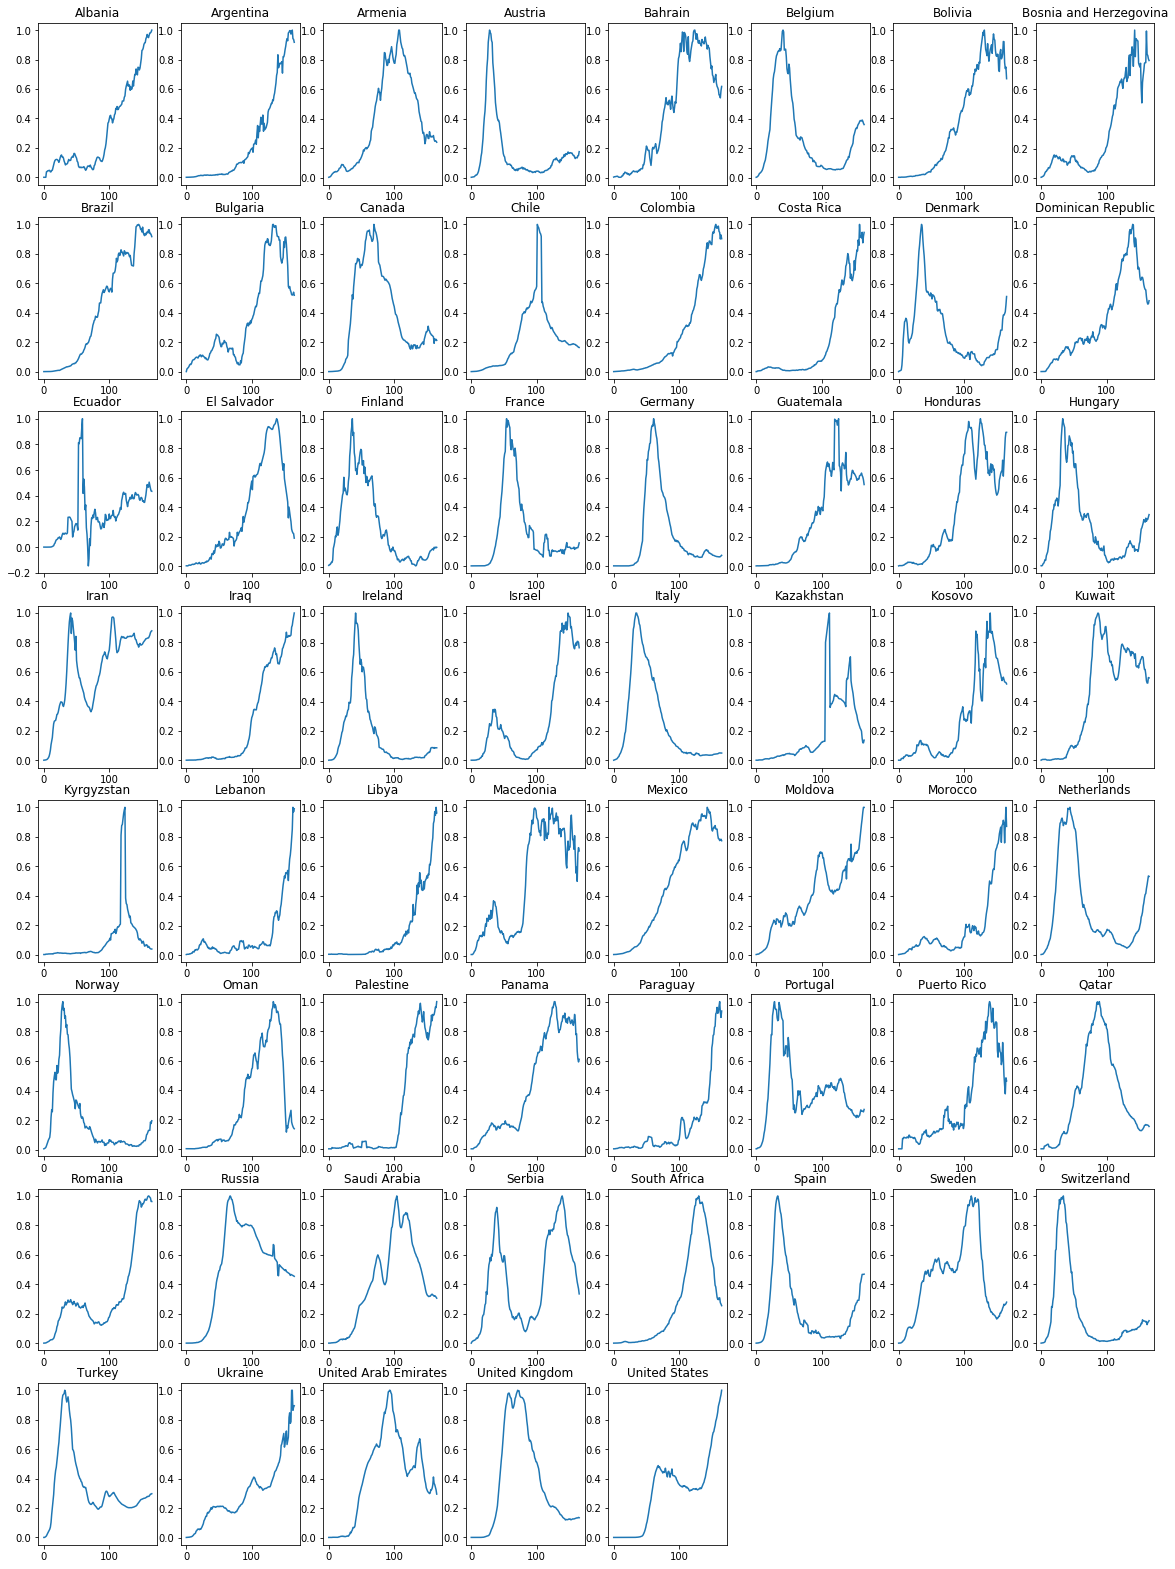

In [432]:
max_cols=8
max_rows=int(len(countries)/max_cols)+1

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))
for idx, countrycode  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].set_title(countrycode)
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [433]:
pca = PCA(n_components=10)
pca.fit(dat)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [434]:
pca.explained_variance_ratio_

array([0.48565371, 0.246306  , 0.10568065, 0.0652472 , 0.03887103,
       0.0144944 , 0.0072754 , 0.00629332, 0.00511845, 0.00367545])

In [435]:
pca.singular_values_

array([18.9111755 , 13.46767628,  8.82171282,  6.93164173,  5.35017748,
        3.26704616,  2.31464024,  2.15275697,  1.94144226,  1.64516827])

### PCA components

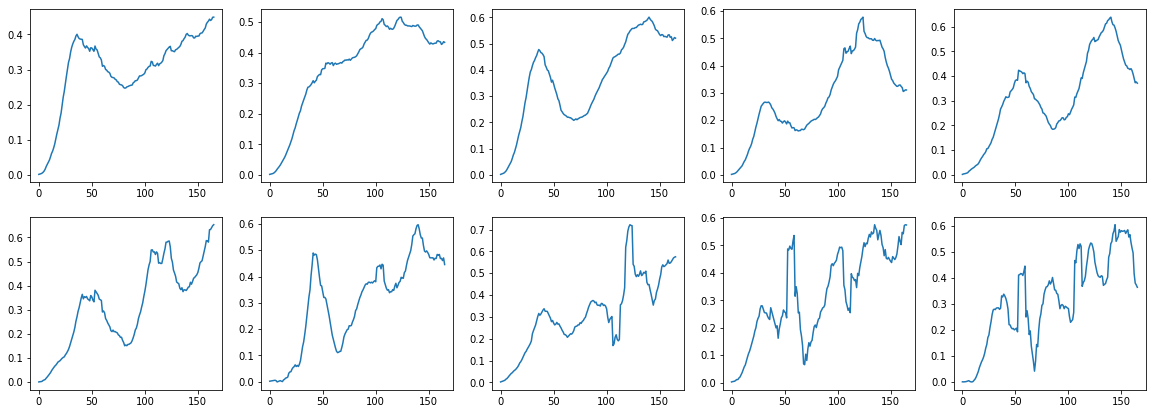

In [436]:
max_rows = 2
max_cols = 5
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
for i in range(10):
    foo = np.zeros(10)
    foo[i] = 1
    mypca = pca.inverse_transform(foo)
    row = i // max_cols
    col = i % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(mypca)

In [437]:
fitted = pca.fit_transform(dat)

In [438]:
smoothed = pca.inverse_transform(fitted)

### Raw + PCA smoothed

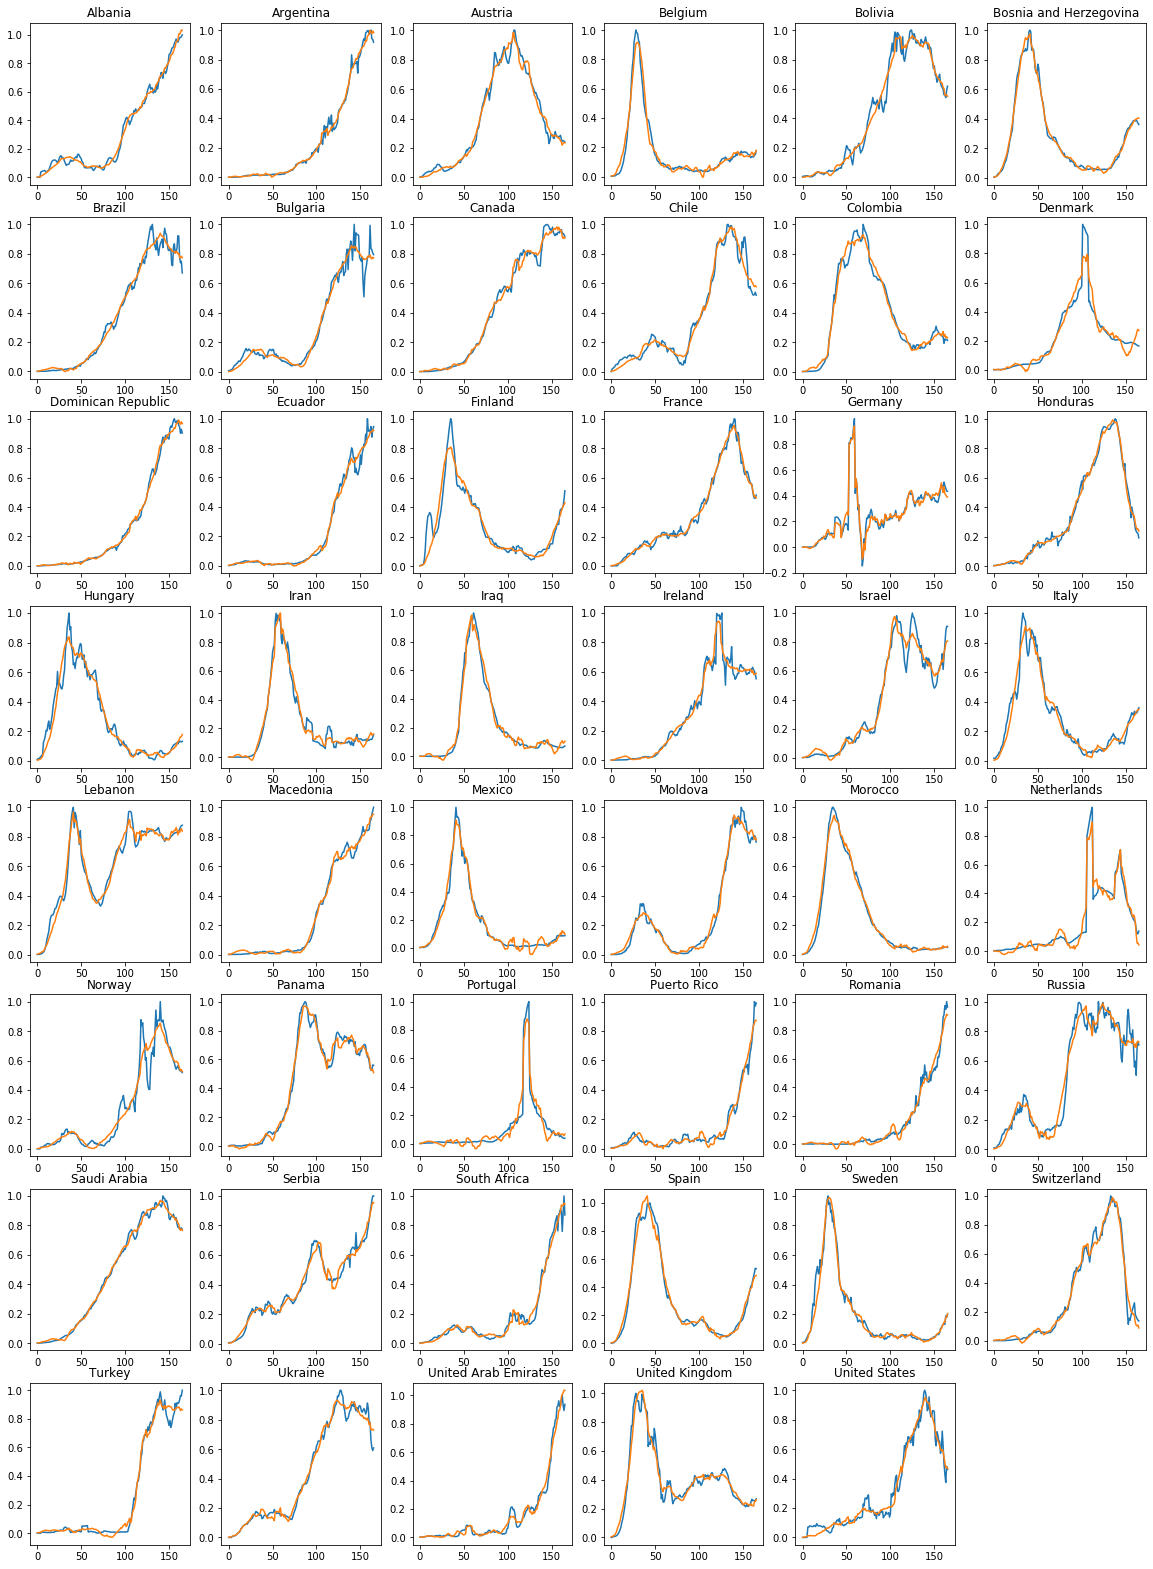

In [439]:
max_cols=6
max_rows=int(len(longshort_c)/max_cols) + 1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))

lcountries = [cc for cc in longshort_c]
for idx, countrycode  in enumerate(lcountries):
    row = idx // max_cols
    col = idx % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
for idx in range(len(lcountries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

## UMAP

In [440]:
um_fit = umap.UMAP(random_state=52,n_neighbors=10).fit(fitted)

### 2 clusters

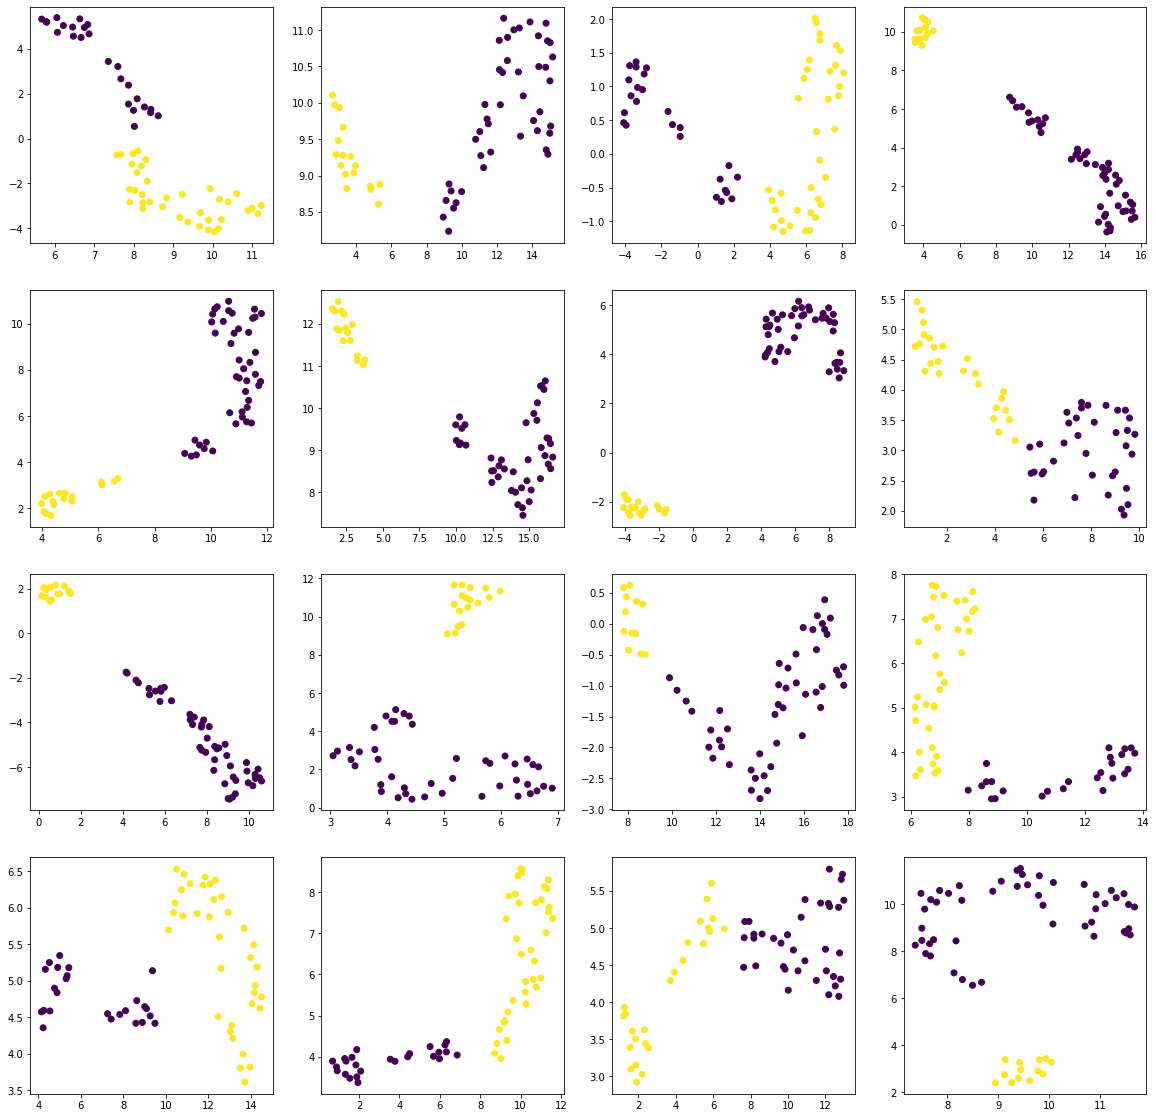

In [441]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=2)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)

### 3 clusters

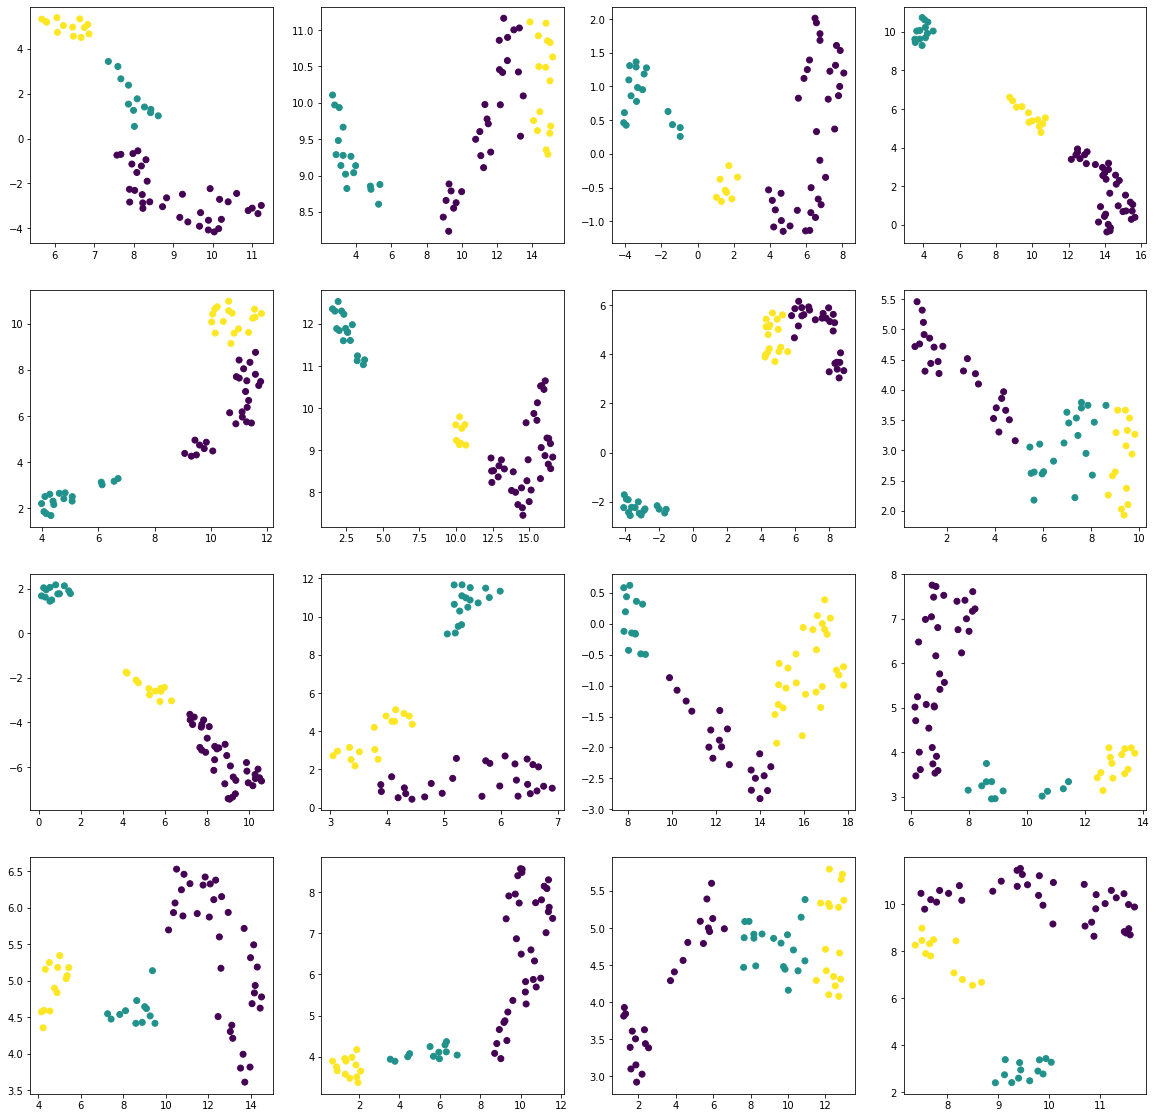

In [442]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=3)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)

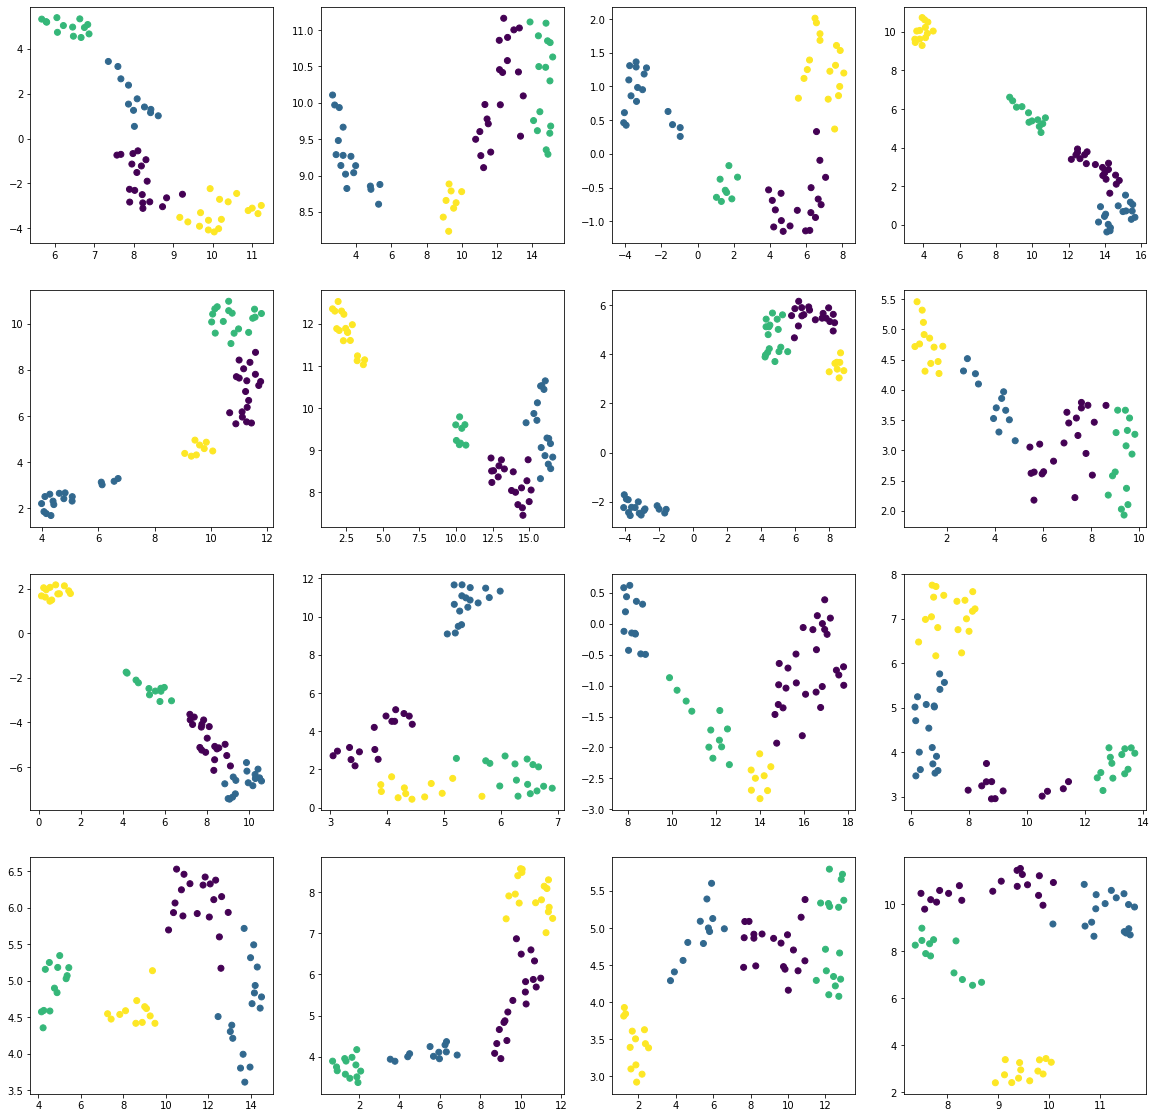

In [443]:
classes = []

fig, axes = plt.subplots(4,4,figsize=(20,20))
agclus = AgglomerativeClustering(n_clusters=4)
for i in range(16):
    um_fit = umap.UMAP(random_state=i,n_neighbors=10).fit(fitted)
    umdat = um_fit.embedding_
    aglabs = agclus.fit_predict(umdat)
    row = i // 4
    col = i % 4
    axes[row,col].scatter(umdat[:,0],umdat[:,1],c=aglabs)
    classes.append(aglabs)

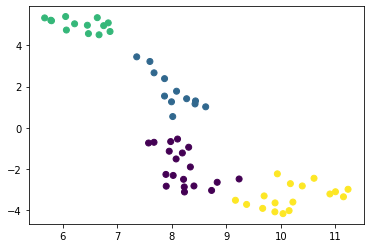

In [444]:
um_fit = umap.UMAP(random_state=0,n_neighbors=10).fit(fitted)
umdat = um_fit.embedding_
aglabs = agclus.fit_predict(umdat)
plt.scatter(umdat[:,0],umdat[:,1],c=aglabs)

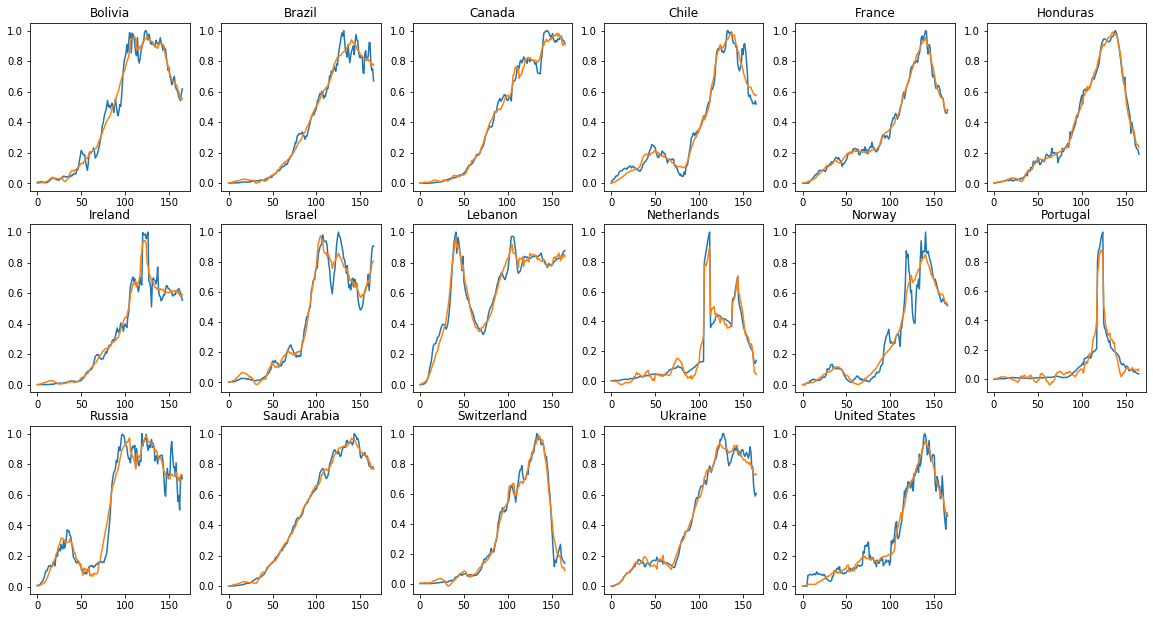

In [445]:
# cluster 0
blob = [i for i in range(len(longshort_c)) if aglabs[i]==0]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

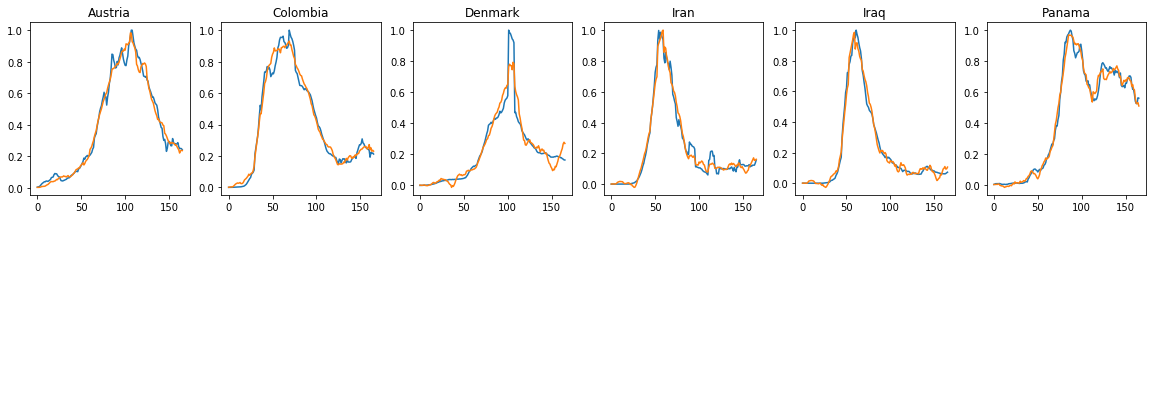

In [446]:
# cluster 1
blob = [i for i in range(len(longshort_c)) if aglabs[i]==1]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

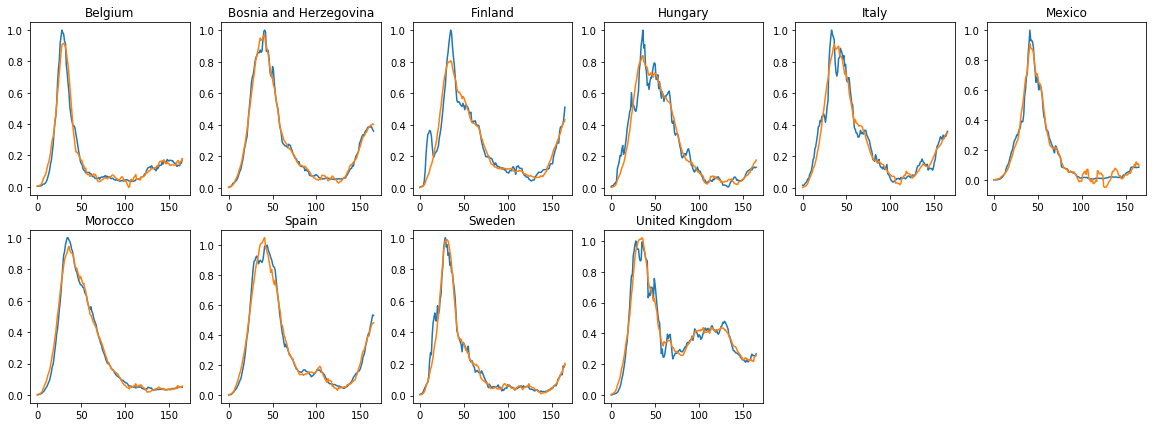

In [447]:
# cluster 2
blob = [i for i in range(len(longshort_c)) if aglabs[i]==2]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

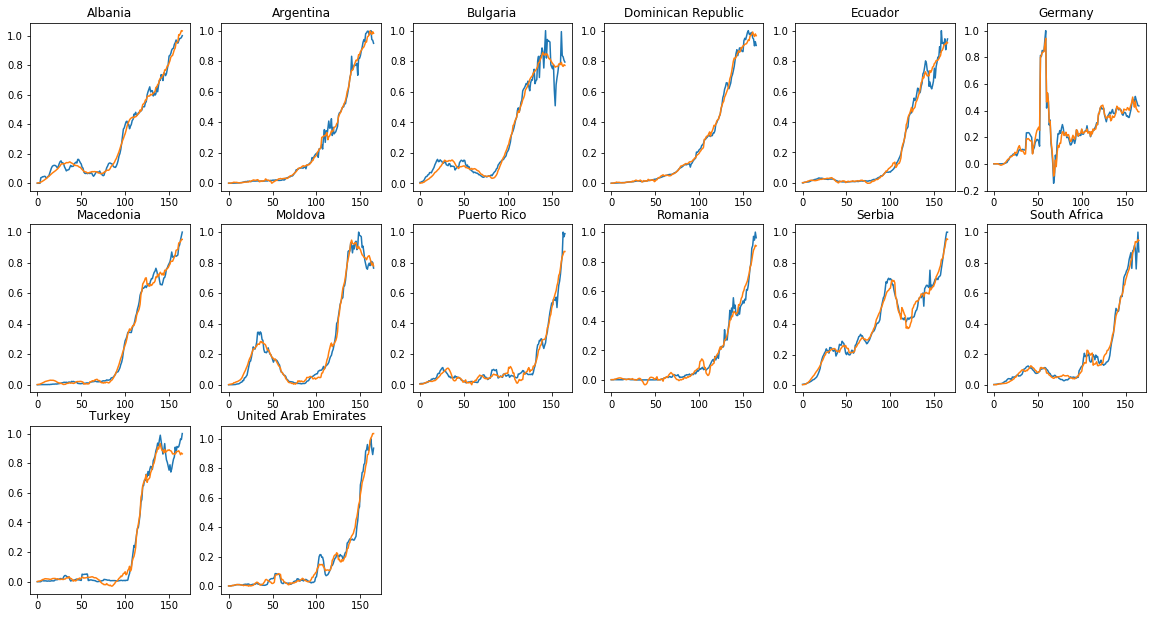

In [448]:
# cluster 3
blob = [i for i in range(len(longshort_c)) if aglabs[i]==3]
max_cols=6
max_rows=int(len(blob)/max_cols)+1
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
lcountries = [cc for cc in longshort_c]
these = [(i,lcountries[i]) for i in blob]
cnt = 0
for idx, countrycode  in these:
    row = cnt // max_cols
    col = cnt % max_cols
    #axes[row, col].axis("off")
    axes[row, col].plot(dat[idx])
    axes[row, col].plot(smoothed[idx])
    axes[row, col].set_title(countrycode)
    cnt = cnt+1
for idx in range(len(blob),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()